In [257]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA, PCA
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score, log_loss, classification_report, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer
import time
import warnings
warnings.filterwarnings("ignore")

# Загружаем датафрейм в Jupyter Notebook и выводим первые пять строк таблицы.

In [258]:
df = pd.read_csv('data01.csv')
df.head()

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,72,1,37.588179,0,0,0,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,0.0,75,2,NaN,0,0,0,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,0.0,83,2,26.572634,0,0,0,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,0.0,43,2,83.264629,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,138290,0.0,75,2,31.824842,1,0,0,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


# Проанализируем столбцы-признаки и целевую переменную.

Для начала можно выделить два столбца, которые не несут информацию о пациентах, кроме их индвидуального номера. Это солбцы group и ID. Удалим ихз их датафрейма, после чего посмотрим оставшиеся признаки.

In [259]:
df = df.drop(['group','ID'], axis = 1)

In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   outcome                   1176 non-null   float64
 1   age                       1177 non-null   int64  
 2   gendera                   1177 non-null   int64  
 3   BMI                       962 non-null    float64
 4   hypertensive              1177 non-null   int64  
 5   atrialfibrillation        1177 non-null   int64  
 6   CHD with no MI            1177 non-null   int64  
 7   diabetes                  1177 non-null   int64  
 8   deficiencyanemias         1177 non-null   int64  
 9   depression                1177 non-null   int64  
 10  Hyperlipemia              1177 non-null   int64  
 11  Renal failure             1177 non-null   int64  
 12  COPD                      1177 non-null   int64  
 13  heart rate                1164 non-null   float64
 14  Systolic

Как видим, общее число наблюдений равняется 1177. Большая часть признаков не содержит пропусков. Некоторые столбцы содержат около 300 пропусков, поэтому обратим на них особое внимание.

Также наблюдаем один пропуск в столбце outcome. Удалим данное наблюдение.

In [261]:
df = df[df.outcome.isna() == False]

In [262]:
df.outcome = df.outcome.astype('int64')
df.age = df.age.astype('float64')

Проанализируем целевую перменную outcome, где 0 - пациент жив, 1 - пациент умер.

In [263]:
print('Общее количество умерших пациентов:',df.outcome.sum())
print('Процентное отношение умерших пациентов:',df.outcome.sum()/len(df)*100)

Общее количество умерших пациентов: 159
Процентное отношение умерших пациентов: 13.520408163265307


Получили, что из 1176 (одно наблюдение убрано) пациентов по полученным данным умерло 159, в процентном отношении 13%. В итоге можно сделать вывод, что наши классы несбалансированы, поскольку класс 1 (пациент умер) занимет только 13% всего датасета.

Построим корреляционную матрицу, чтобы проанализировать связь признаков между собой и целевой переменной.

<AxesSubplot:>

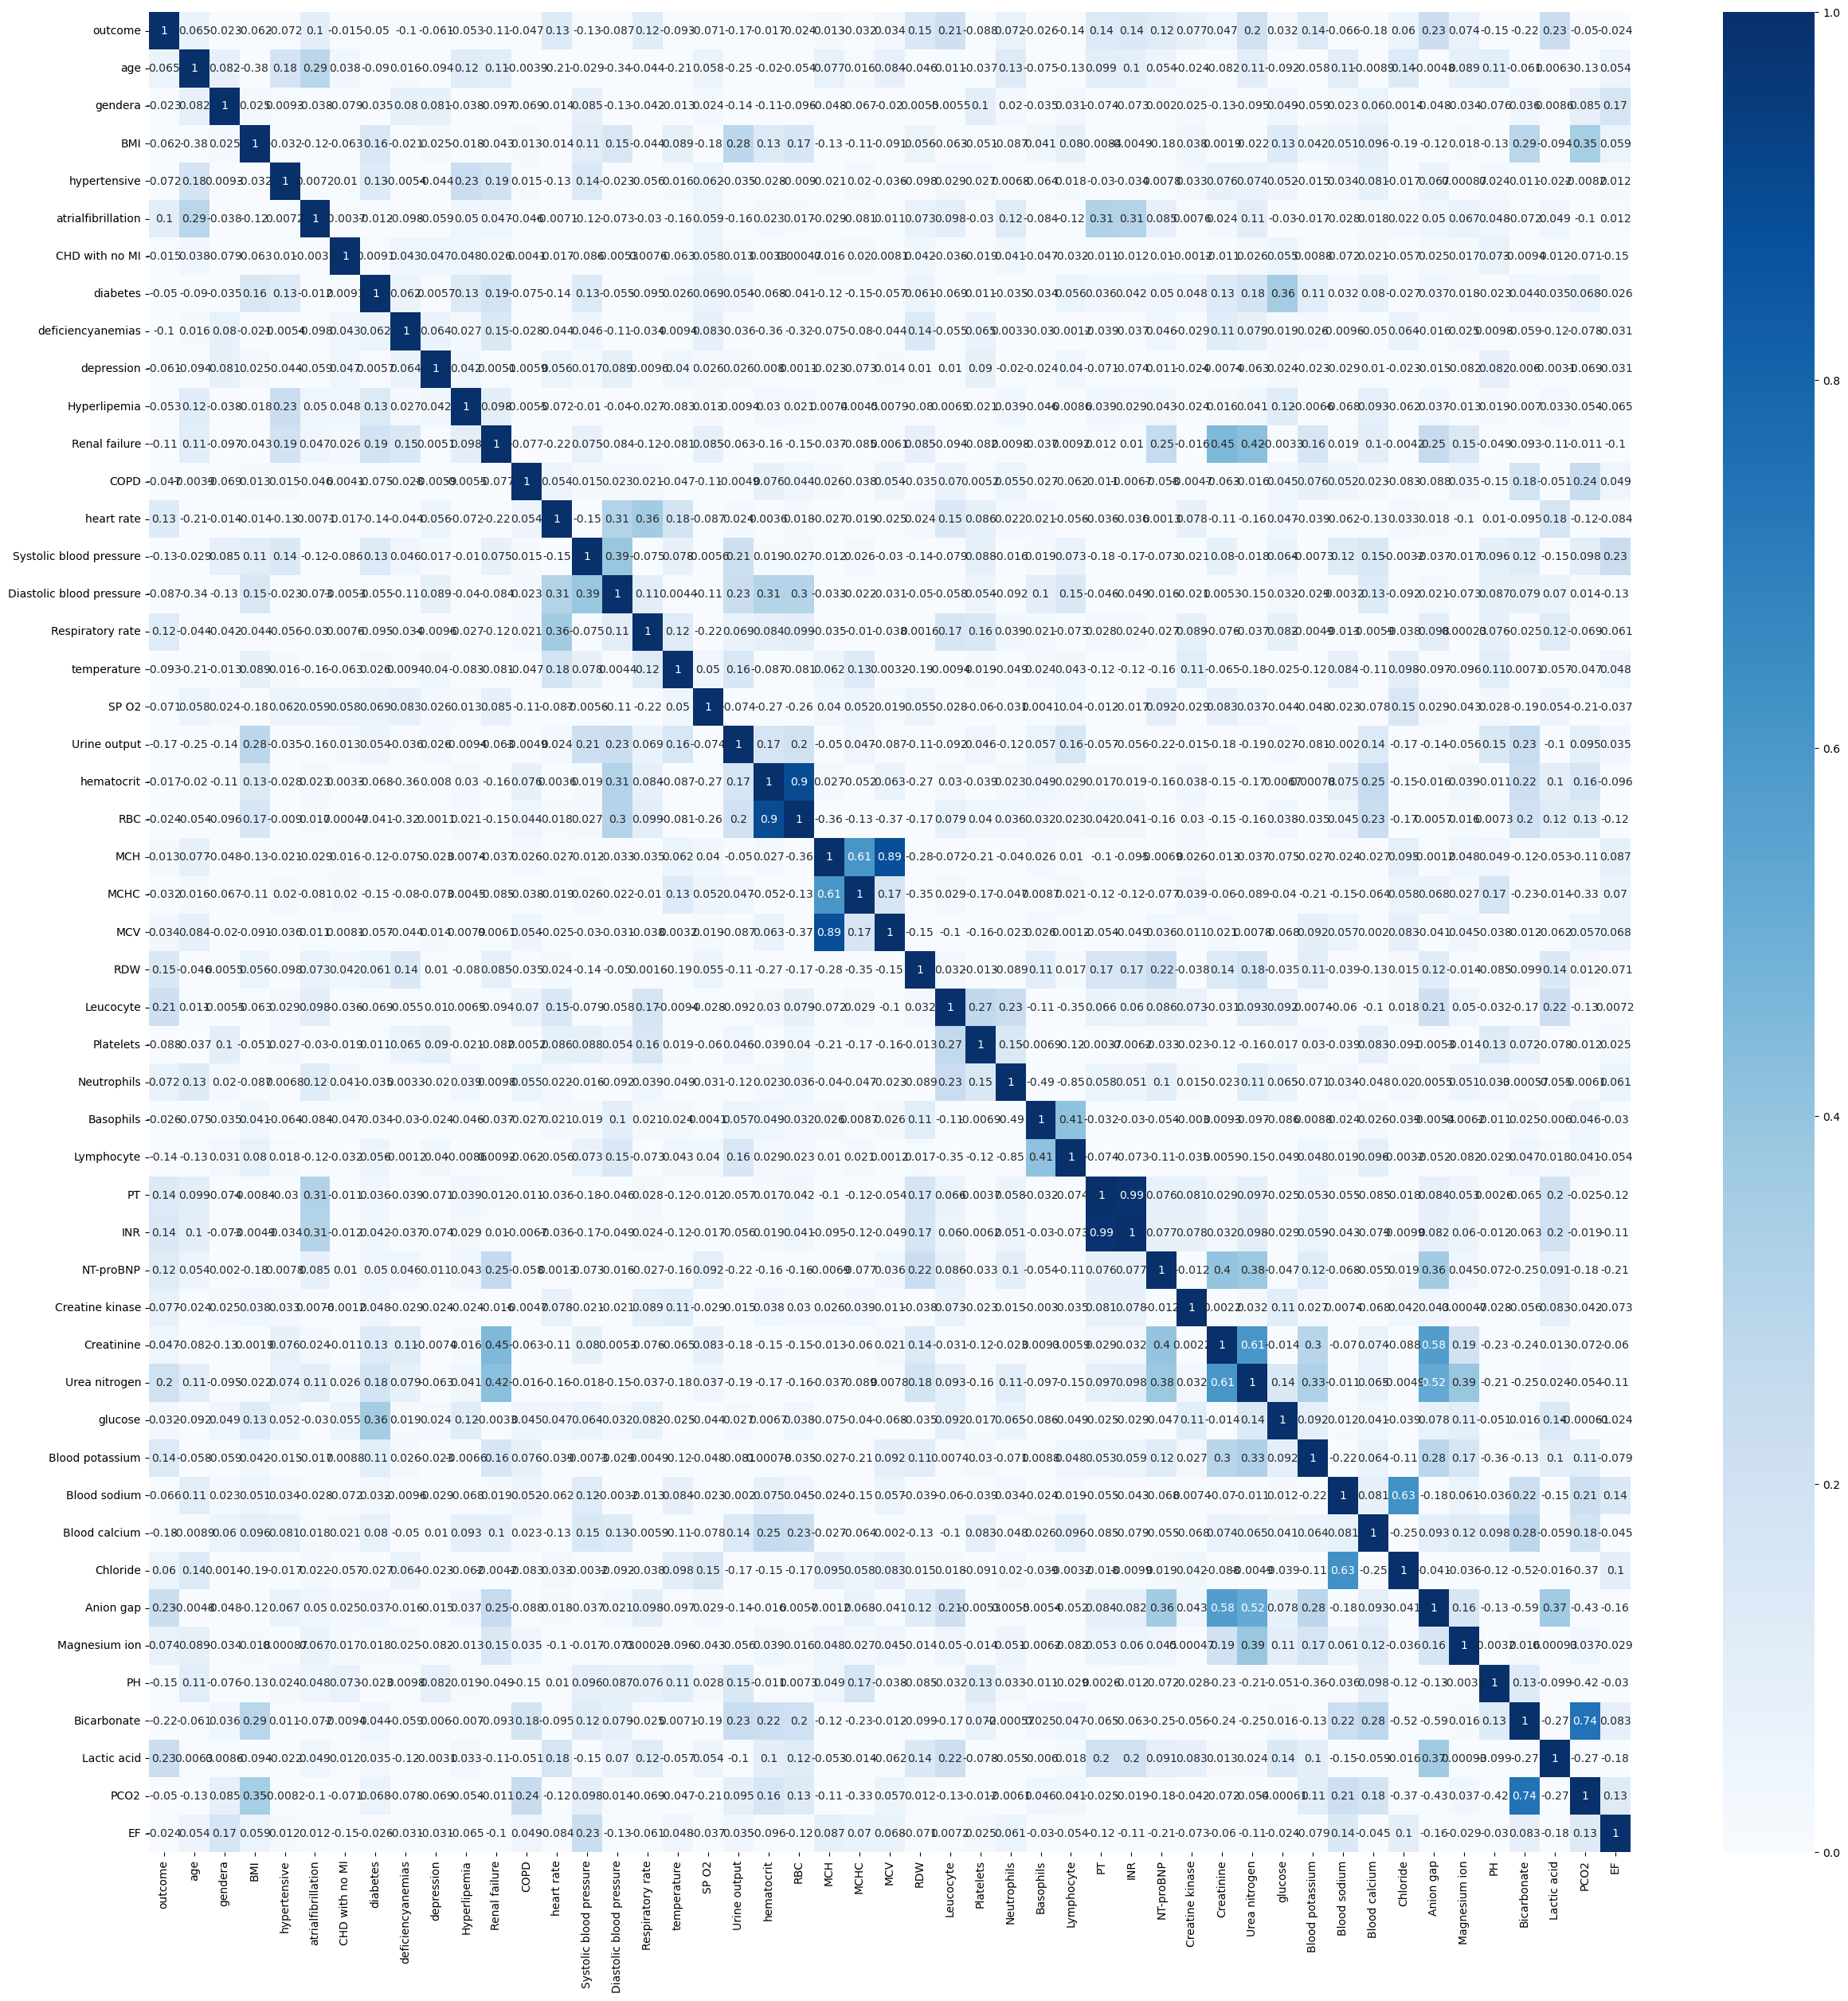

In [264]:
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(), vmin=0, vmax=1, cmap = 'Blues', annot = True)

Заметим, что почти все признаки оказывают влияение на целевую переменную. Рассмотрим признаки, которые сильно коррелируют между собой, чтобы исключить некоторые из построения модели. Оставим их для дальнейшего использования и сравнения с выбранными признаками.

Сильную корреляцию имеют признаки:

Bicarbonate и PCO2 - 0.74

MCHC и MCV - 0.89

Hematocrit и RBC - 0.9

PT и INR - 0.99

Исключим из модели следующие признаки:

PCO2 - содержит больше пропусков, чем Bicarbonate и оказывает меньшее влияние на outcome

MCV - оказывает меньшее влияние на outcome

hematocrit - оказывает меньшее влияние на outcome

INR - оказывает равное с PT влияение на outcome и количество пропусков. Выбираем любое.

In [265]:
df = df.drop(['PCO2','MCV','hematocrit','INR'], axis= 1)

Посмотрим на признаки с пропусками.

In [266]:
df.columns[df.isna().sum(axis = 0)>0]

Index(['BMI', 'heart rate', 'Systolic blood pressure',
       'Diastolic blood pressure', 'Respiratory rate', 'temperature', 'SP O2',
       'Urine output', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT',
       'Creatine kinase', 'glucose', 'Blood calcium', 'PH', 'Lactic acid'],
      dtype='object')

BMI:

<AxesSubplot:>

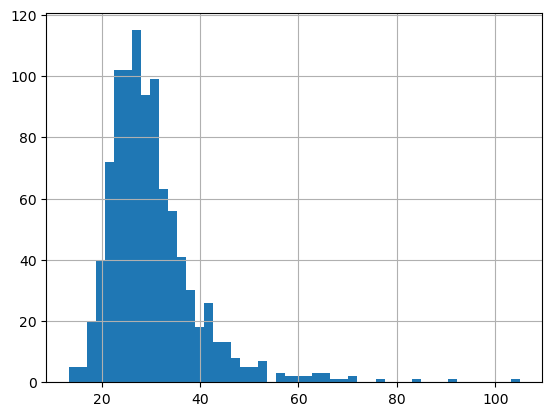

In [267]:
df['BMI'].hist(bins = 50)

In [268]:
df['BMI'] = df['BMI'].fillna(df['BMI'].median())

Признак является непрерывным, распределение напоминает нормальное с положительным отклонением. Для заполнения пропусков по этому столбцу будем использовать медиану.

heart rate:

<AxesSubplot:>

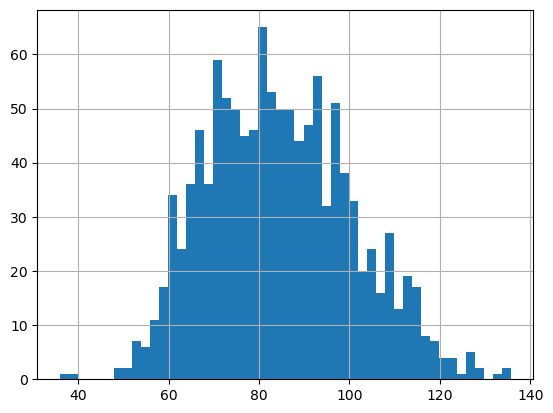

In [269]:
df['heart rate'].hist(bins = 50)

In [270]:
df['heart rate'] = df['heart rate'].fillna(df['heart rate'].mean())

Признак является непрерывным, распределение напоминает нормальное. Для заполнения пропусков по этому столбцу будем использовать среднее.

Systolic blood pressure:

<AxesSubplot:>

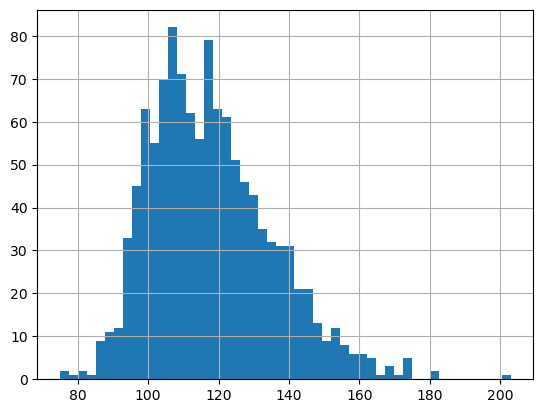

In [271]:
df['Systolic blood pressure'].hist(bins = 50)

In [272]:
df['Systolic blood pressure'] = df['Systolic blood pressure'].fillna(df['Systolic blood pressure'].median())

Признак является непрерывным, распределение напоминает нормальное с небольшим положительным отклонением. Для заполнения пропусков по этому столбцу будем использовать медиану.

Diastolic blood pressure:

<AxesSubplot:>

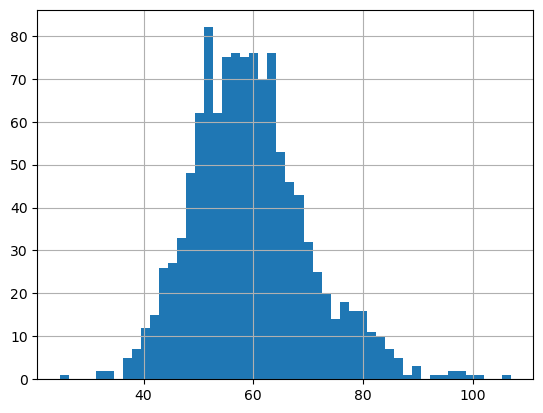

In [273]:
df['Diastolic blood pressure'].hist(bins = 50)

In [274]:
df['Diastolic blood pressure'] = df['Diastolic blood pressure'].fillna(df['Diastolic blood pressure'].mean())

Признак является непрерывным, распределение напоминает нормальное. Для заполнения пропусков по этому столбцу будем использовать среднее.

Respiratory rate:

<AxesSubplot:>

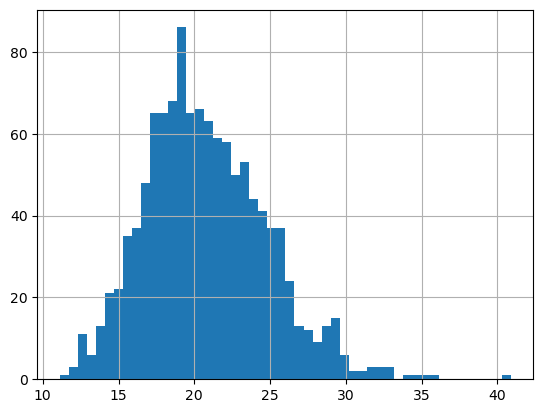

In [275]:
df['Respiratory rate'].hist(bins = 50)

In [276]:
df['Respiratory rate'] = df['Respiratory rate'].fillna(df['Respiratory rate'].median())

Признак является непрерывным, распределение напоминает нормальное с небольшим положительным отклонением. Для заполнения пропусков по этому столбцу будем использовать медиану.

temperature:

<AxesSubplot:>

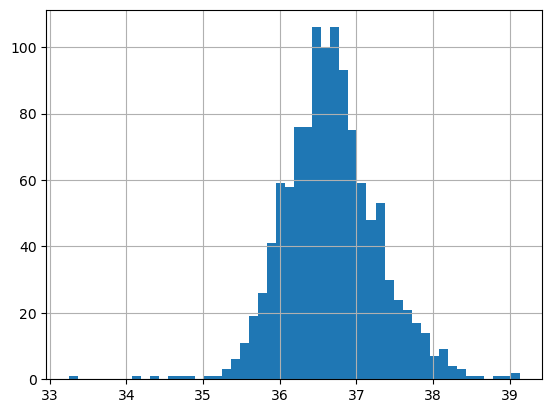

In [277]:
df['temperature'].hist(bins=50)

In [278]:
df['temperature'] = df['temperature'].fillna(df['temperature'].median())

Признак является непрерывным, распределение напоминает нормальное c небольшим отрицательным отклонением. Для заполнения пропусков по этому столбцу будем использовать медиану.

SP O2:

<AxesSubplot:>

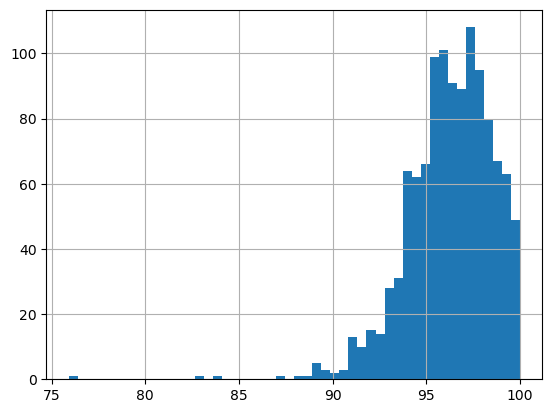

In [279]:
df['SP O2'].hist(bins = 50)

In [280]:
df['SP O2'] = df['SP O2'].fillna(df['SP O2'].median())

Признак является непрерывным, распределение напоминает нормальное c отрицательным отклонением. Для заполнения пропусков по этому столбцу будем использовать медиану.

Urine output:

<AxesSubplot:>

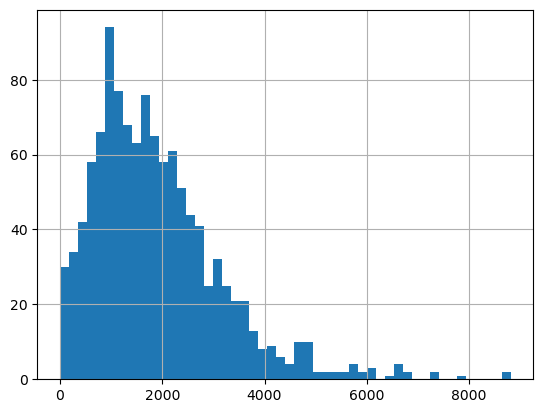

In [281]:
df['Urine output'].hist(bins = 50)

In [282]:
df['Urine output'] = df['Urine output'].fillna(df['Urine output'].median())

Признак является непрерывным, распределение напоминает нормальное c положительным отклонением. Для заполнения пропусков по этому столбцу будем использовать медиану.

Neutrophils:

<AxesSubplot:>

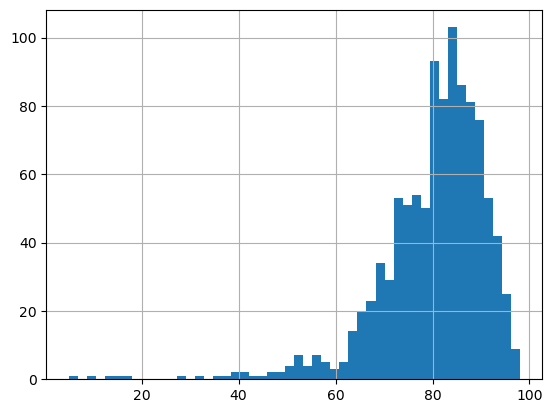

In [283]:
df['Neutrophils'].hist(bins = 50)

In [284]:
df['Neutrophils'] = df['Neutrophils'].fillna(df['Neutrophils'].median())

Признак является непрерывным, распределение напоминает нормальное c отрицательным отклонением. Для заполнения пропусков по этому столбцу будем использовать медиану.

Basophils:

<AxesSubplot:>

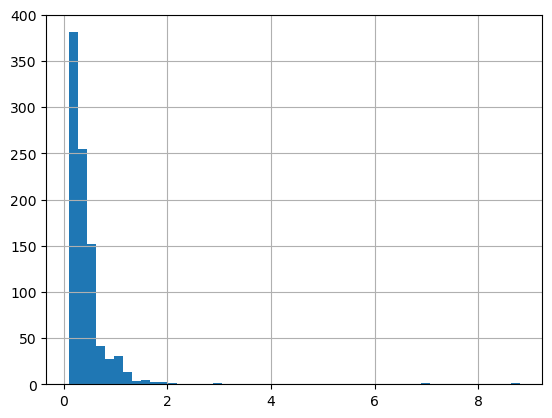

In [285]:
df['Basophils'].hist(bins = 50)

Признак является непрерывным, распределение не похоже на нормальное, возможно наличие выбросов. Для заполнения пропусков по этому столбцу будем использовать медиану.

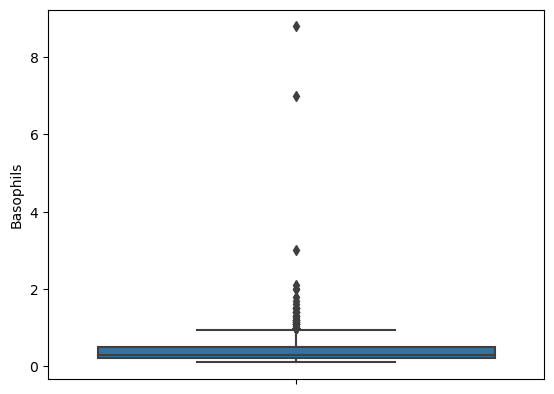

In [286]:
sns.boxplot(y='Basophils', data = df)
plt.show()

На графике видим несколько выбросов, которые могли появится в результате исследований. То есть данные точки не являются ошибкой ввода, поэтому оставляем их для построения модели.

In [287]:
df['Basophils'] = df['Basophils'].fillna(df['Basophils'].median())

Lymphocyte:

<AxesSubplot:>

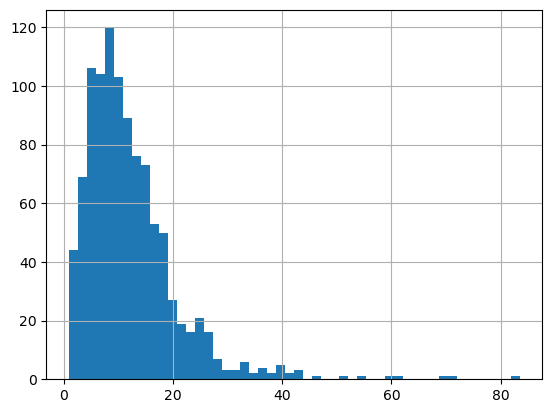

In [288]:
df['Lymphocyte'].hist(bins = 50)

In [289]:
df['Lymphocyte'] = df['Lymphocyte'].fillna(df['Lymphocyte'].median())

Признак является непрерывным, распределение напоминает нормальное c положительным отклонением. Для заполнения пропусков по этому столбцу будем использовать медиану.

PT:

<AxesSubplot:>

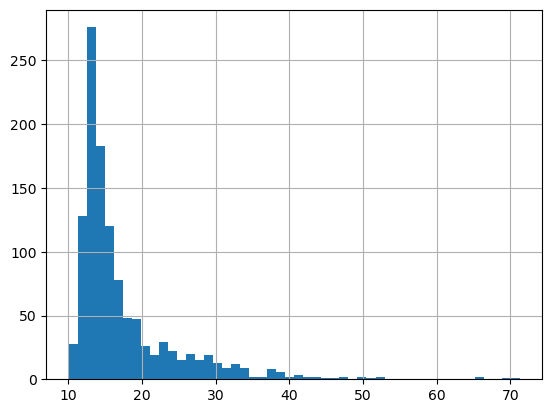

In [290]:
df['PT'].hist(bins = 50)

In [291]:
df['PT'] = df['PT'].fillna(df['PT'].median())

Признак является непрерывным, распределение напоминает нормальное c положительным отклонением. Для заполнения пропусков по этому столбцу будем использовать медиану.

Creatine kinase:

<AxesSubplot:>

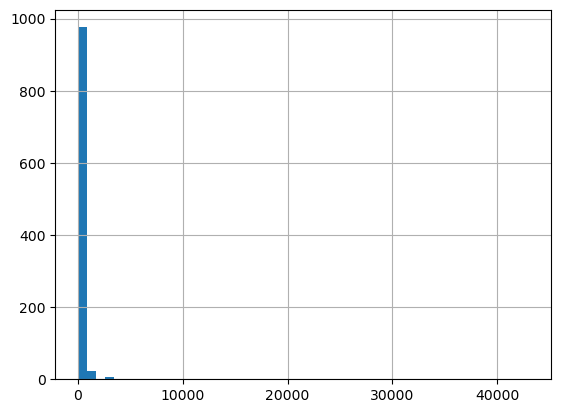

In [292]:
df['Creatine kinase'].hist(bins = 50)

Наблюдаем сильный выброс, который превышает 40000, в то время как большая часть распределены до это значения. Уберем выбросы и посмотрим на распределение еще раз.

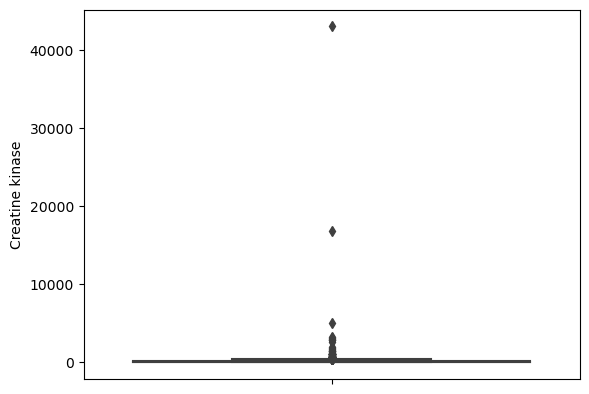

In [293]:
sns.boxplot(y='Creatine kinase', data = df)
plt.show()

Наблюдаем сильные выбросы. Большая часть значений сгруппированы на отрезке от 0 до 1000. Уберем наблюдения, которая однозачно не вписываются в общее распределение.

In [294]:
df = df[df['Creatine kinase'] < 10000]

<AxesSubplot:>

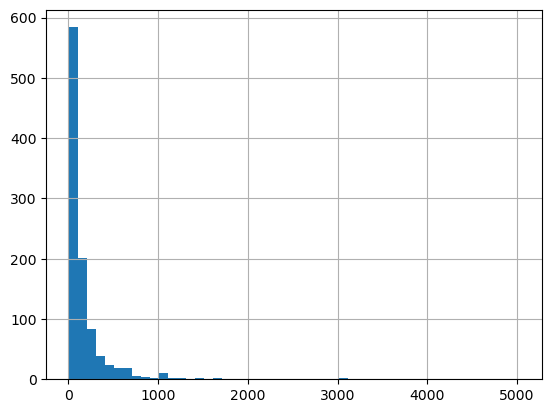

In [295]:
df['Creatine kinase'].hist(bins = 50)

In [296]:
df['Creatine kinase'] = df['Creatine kinase'].fillna(df['Creatine kinase'].median())

Распределение не является нормальным, также наблюдаются сильные выбросы. Для заполнения пропусков будем использовать медиану

glucose:

<AxesSubplot:>

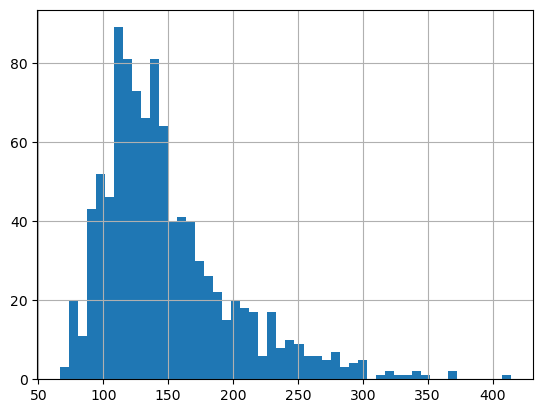

In [297]:
df['glucose'].hist(bins = 50)

In [298]:
df['glucose'] = df['glucose'].fillna(df['glucose'].median())

Признак является непрерывным, распределение напоминает нормальное c положительным отклонением. Для заполнения пропусков по этому столбцу будем использовать медиану.

Blood calcium:

<AxesSubplot:>

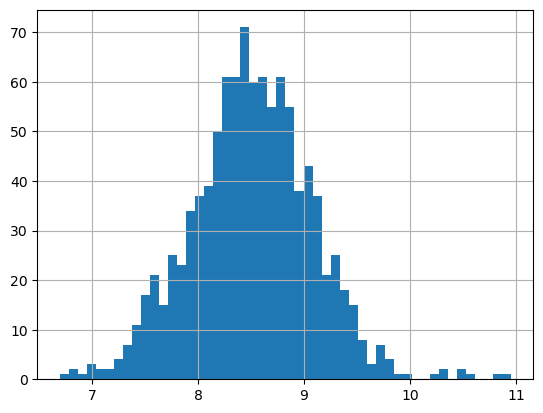

In [299]:
df['Blood calcium'].hist(bins = 50)

In [300]:
df['Blood calcium'] = df['Blood calcium'].fillna(df['Blood calcium'].mean())

Признак является непрерывным, распределение напоминает нормальное. Для заполнения пропусков по этому столбцу будем использовать среднее.

PH:

<AxesSubplot:>

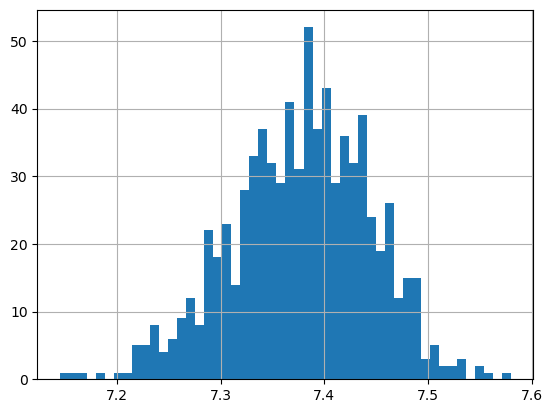

In [301]:
df['PH'].hist(bins = 50)

In [302]:
df['PH'] = df['PH'].fillna(df['PH'].mean())

Признак является непрерывным, распределение напоминает нормальное. Для заполнения пропусков по этому столбцу будем использовать среднее.

Lactic acid:

<AxesSubplot:>

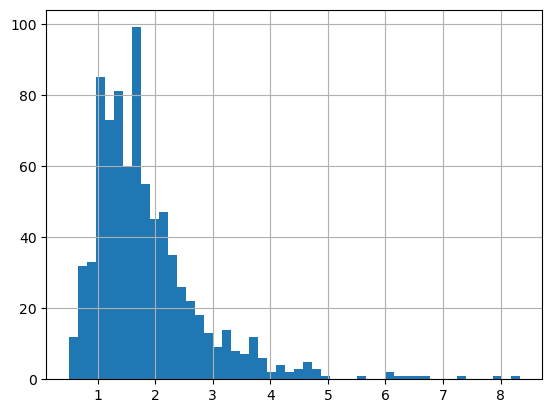

In [303]:
df['Lactic acid'].hist(bins = 50)

In [304]:
df['Lactic acid'] = df['Lactic acid'].fillna(df['Lactic acid'].median())

Признак является непрерывным, распределение напоминает нормальное c положительным отклонением. Для заполнения пропусков по этому столбцу будем использовать медиану.

In [305]:
df.isna().sum(axis = 0)

outcome                     0
age                         0
gendera                     0
BMI                         0
hypertensive                0
atrialfibrillation          0
CHD with no MI              0
diabetes                    0
deficiencyanemias           0
depression                  0
Hyperlipemia                0
Renal failure               0
COPD                        0
heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Respiratory rate            0
temperature                 0
SP O2                       0
Urine output                0
RBC                         0
MCH                         0
MCHC                        0
RDW                         0
Leucocyte                   0
Platelets                   0
Neutrophils                 0
Basophils                   0
Lymphocyte                  0
PT                          0
NT-proBNP                   0
Creatine kinase             0
Creatinine                  0
Urea nitro

В результате были удалены все пропуски и рассмотрены некоторые признаки с выбросами. Проанализируем весь набор признаков. Начнем с категориальных.

In [306]:
col = df.columns[df.dtypes == 'int64']

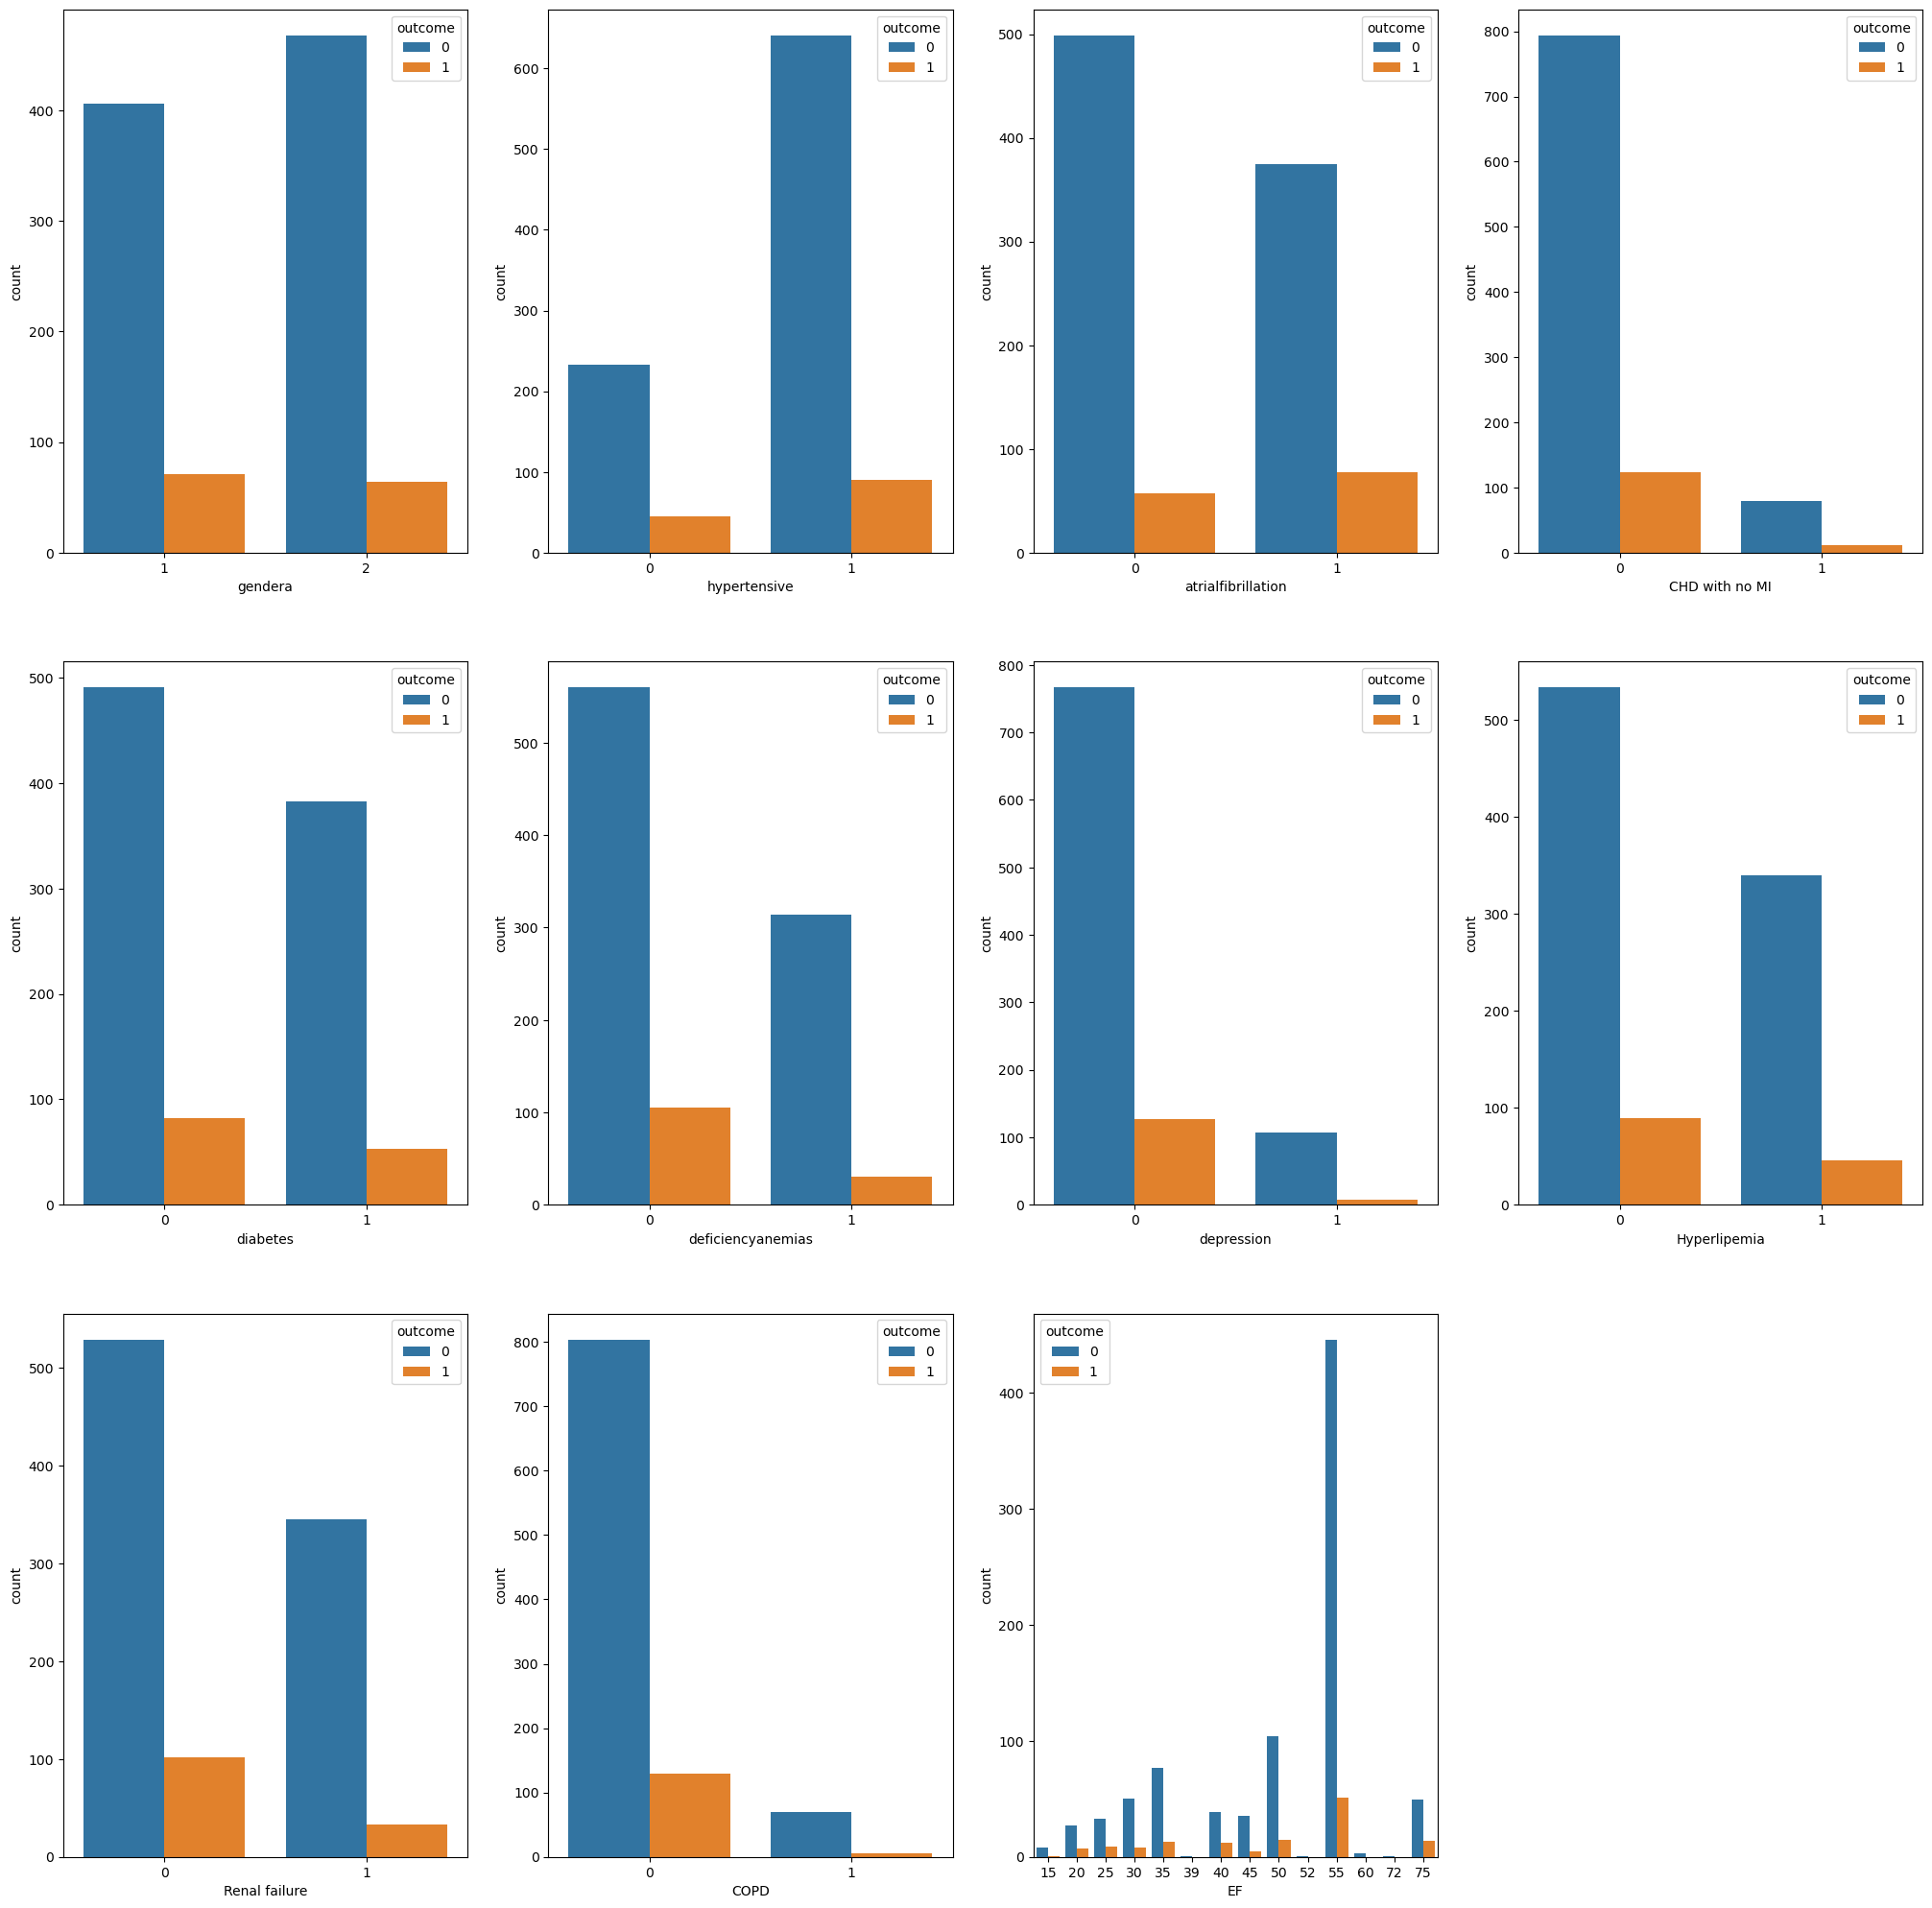

In [307]:
plt.figure(figsize = (25, 25))
for i in range(1, len(col)):
    plt.subplot(3, 4, i)
    sns.countplot(x = df[col[i]], hue = df['outcome'])

Перейдем к непрерывным признакам:

In [308]:
col = df.columns[df.dtypes == 'float64']

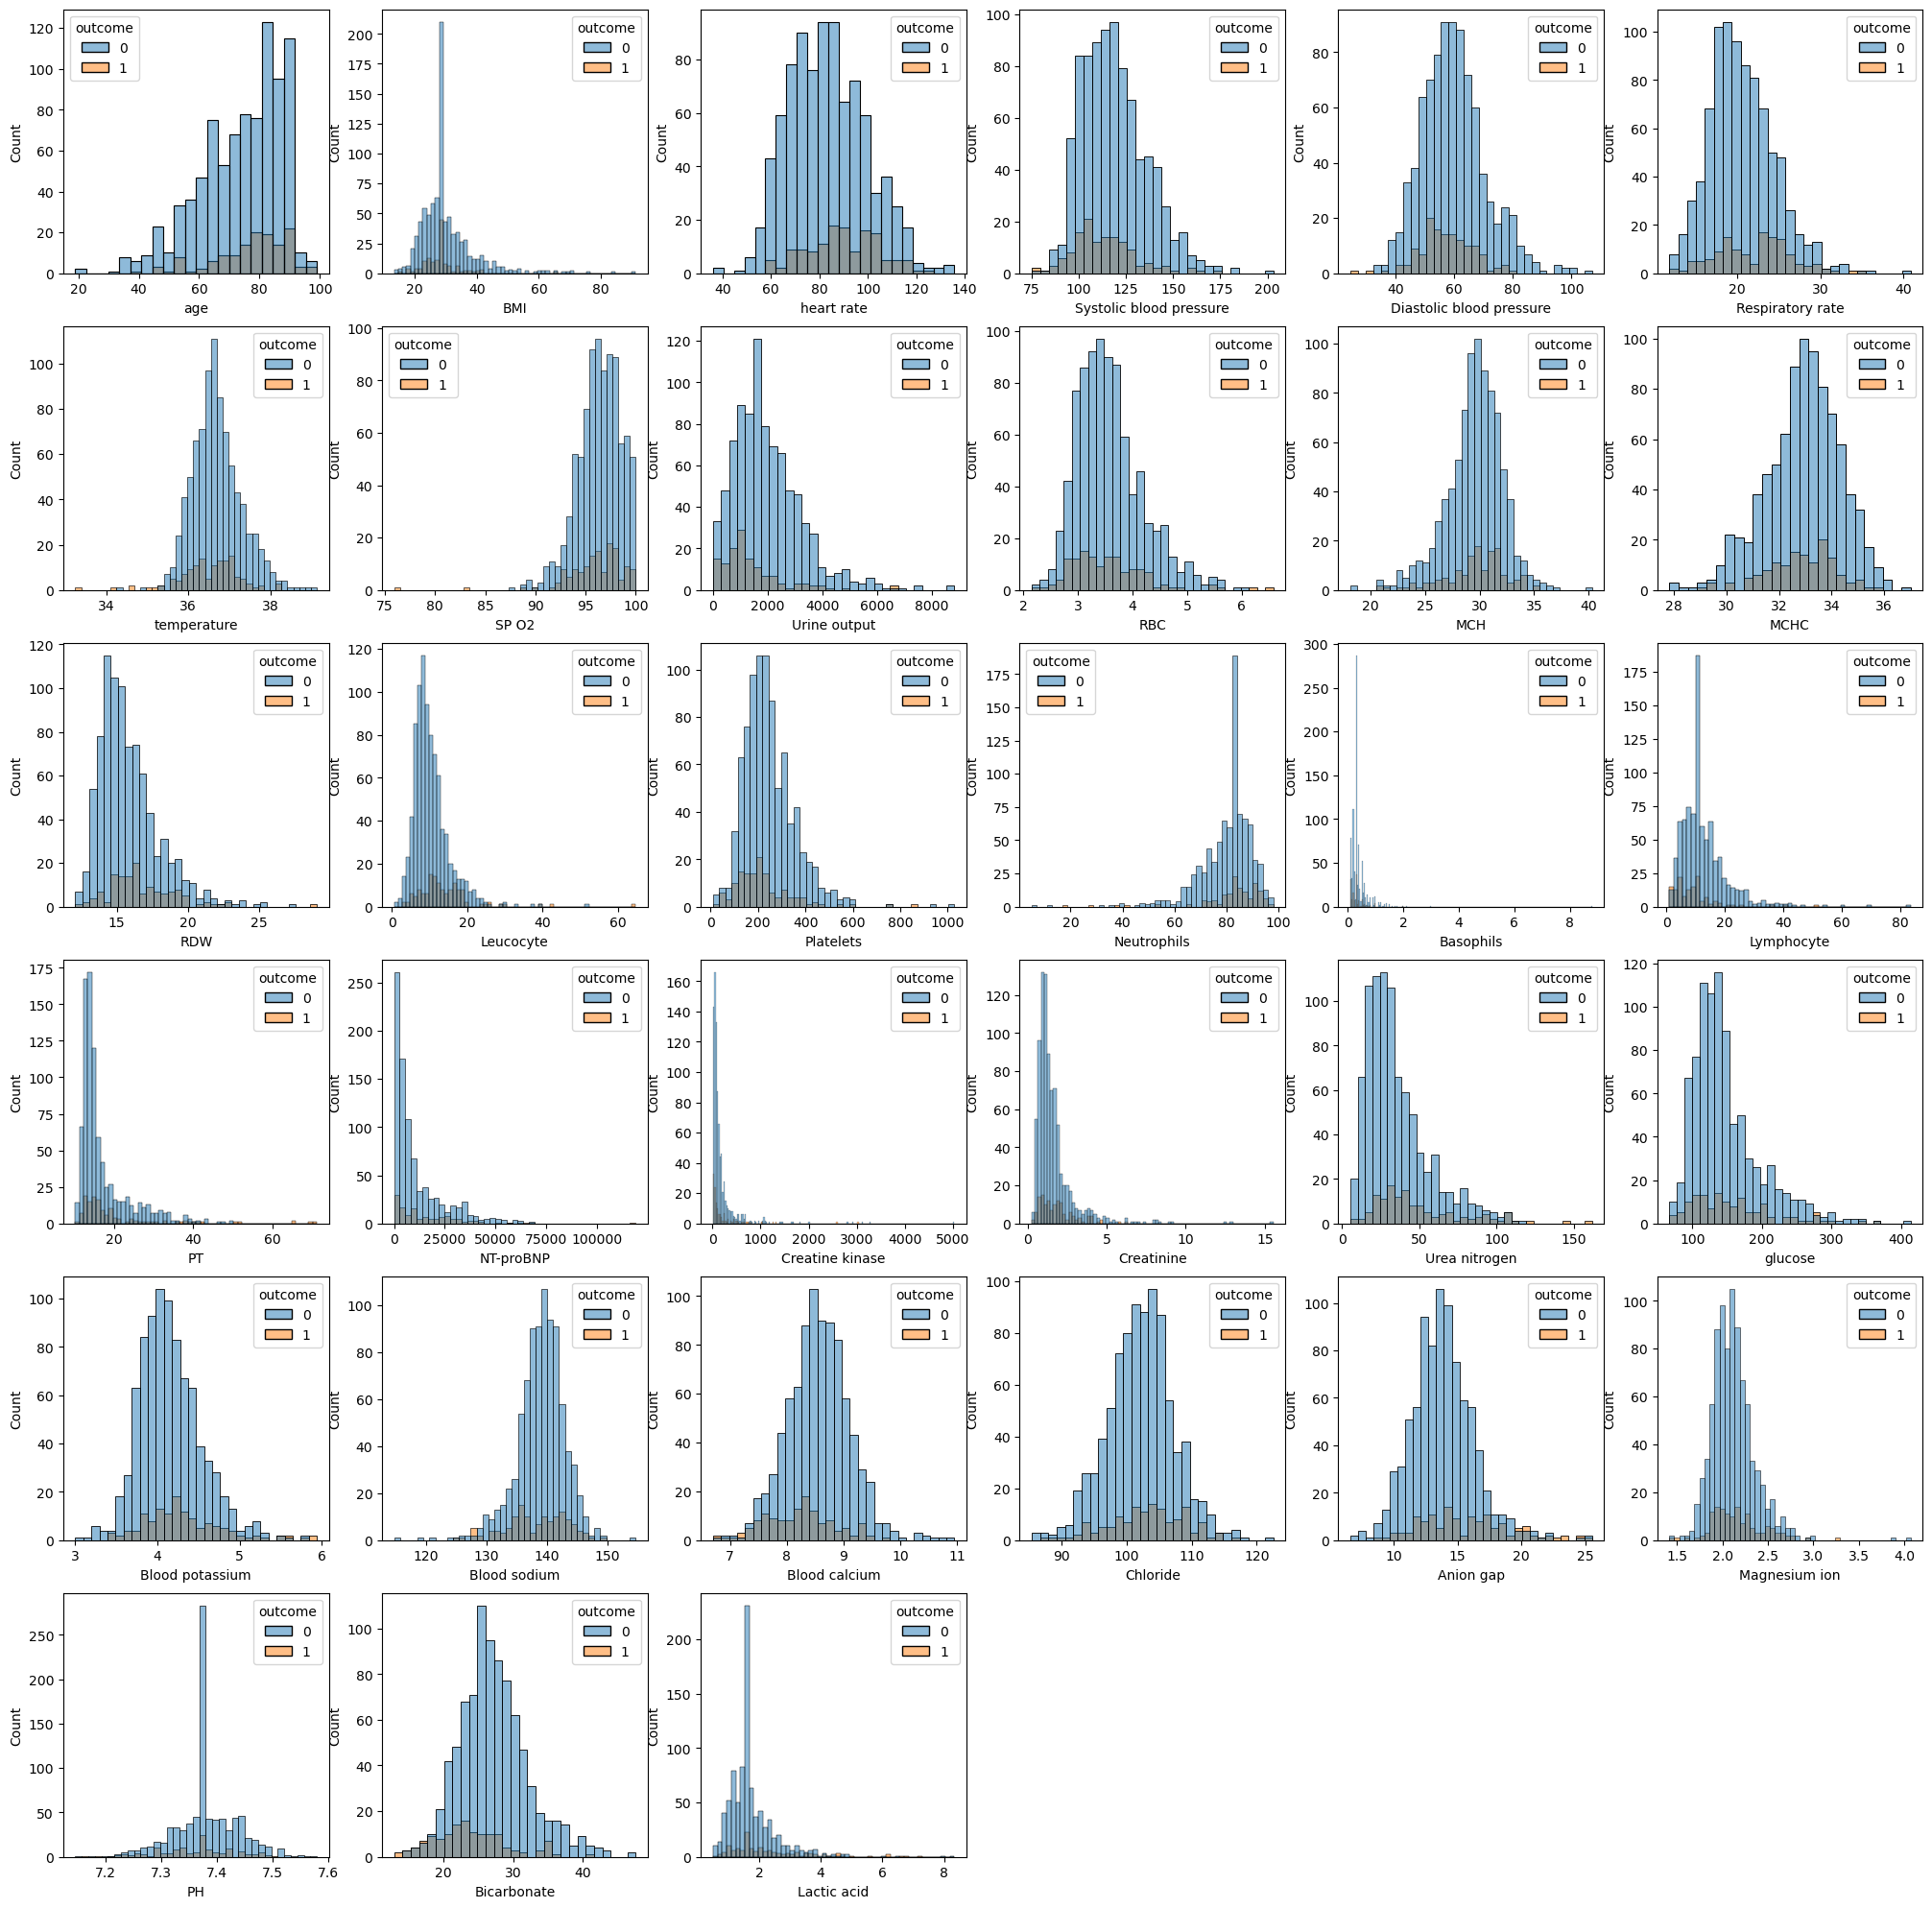

In [309]:
plt.figure(figsize = (25, 25))
for i in range(1, len(col)+1):
    plt.subplot(6, 6, i)
    sns.histplot(data=df, x=col[i-1], hue="outcome")

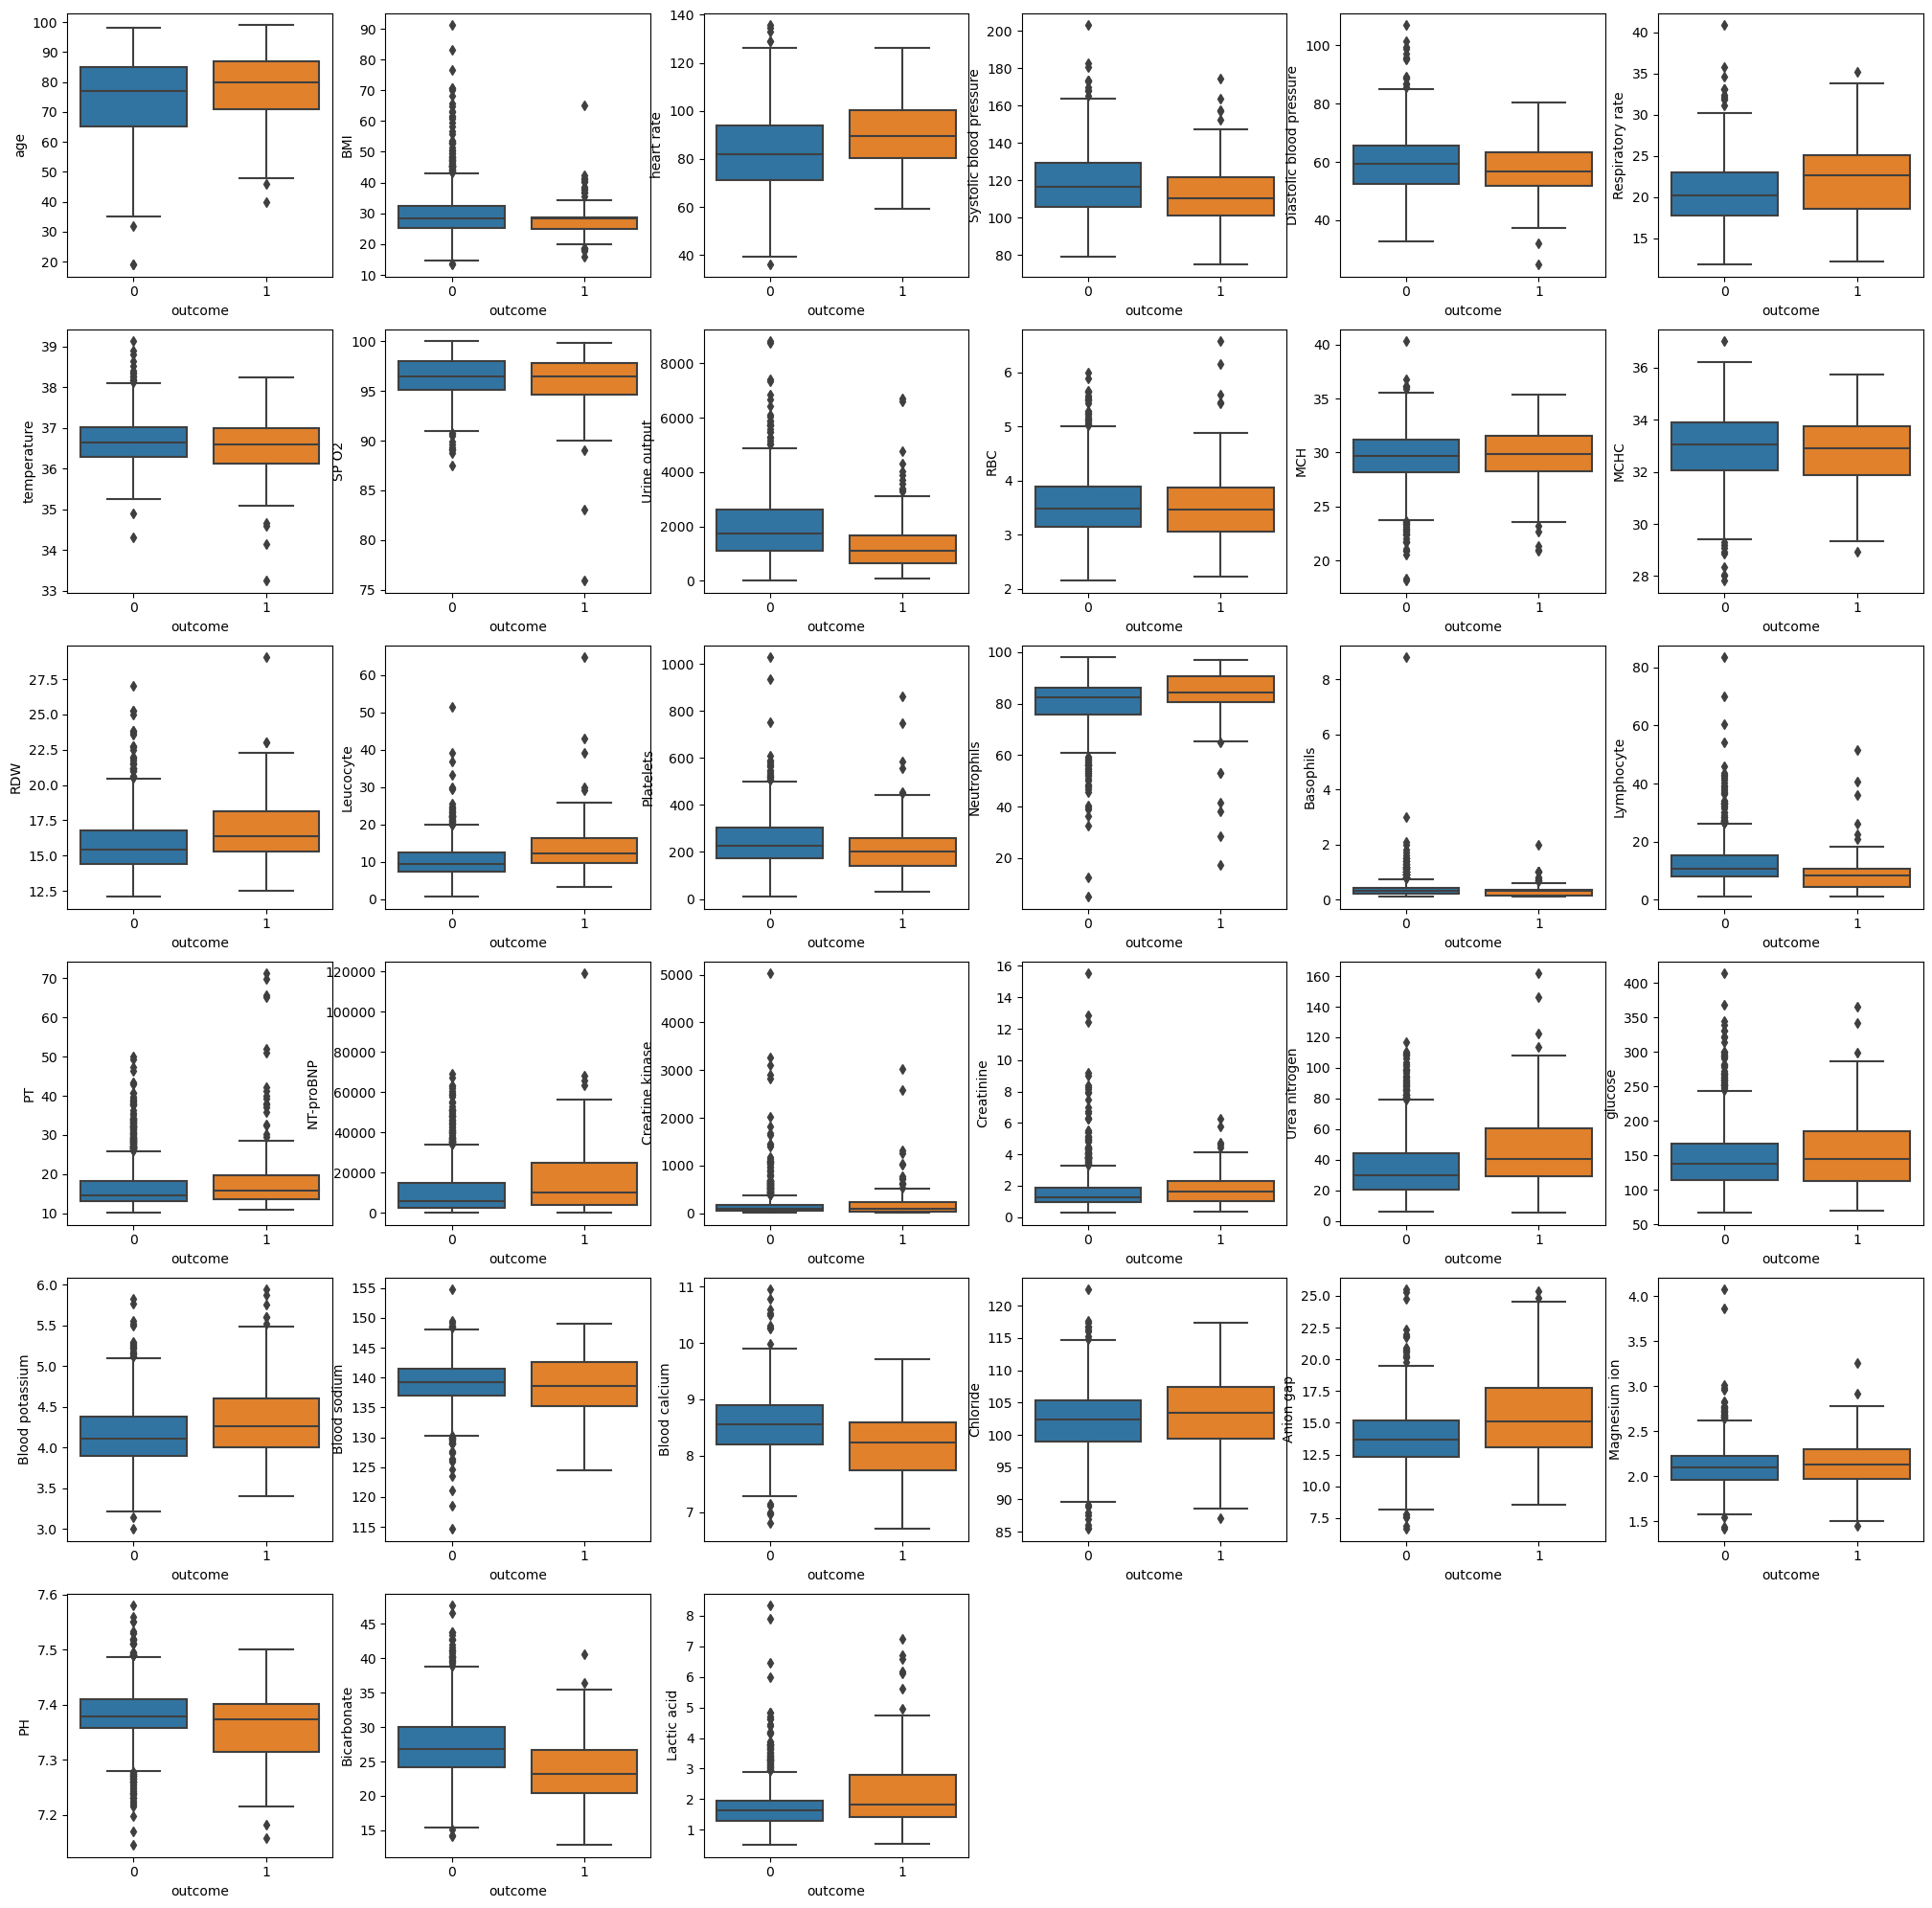

In [310]:
plt.figure(figsize = (25, 25))
for i in range(1, len(col)+1):
    plt.subplot(6, 6, i)
    sns.boxplot(x = 'outcome', y = col[i-1], data = df)

In [311]:
df.describe()

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,...,Blood potassium,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,EF
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,...,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000
mean,0.133796,74.322101,1.527255,29.748153,0.724480,0.448959,0.090188,0.432111,0.340932,0.113974,...,4.177447,138.889998,8.509923,102.270107,14.067093,2.124558,7.377689,26.785975,1.822726,48.511397
std,0.340602,13.323892,0.499504,8.269863,0.446998,0.497635,0.286593,0.495615,0.474257,0.317938,...,0.403502,4.134059,0.569284,5.225377,2.672708,0.246054,0.058441,5.180262,0.891924,12.906029
min,0.000000,19.000000,1.000000,13.346801,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,114.666667,6.700000,85.416667,6.636364,1.414286,7.145000,12.857143,0.500000,15.000000
25%,0.000000,66.000000,1.000000,25.217359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.900000,136.625000,8.157143,99.076923,12.357143,1.962500,7.350000,23.411765,1.300000,40.000000
50%,0.000000,78.000000,2.000000,28.312474,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.120000,139.250000,8.500000,102.444444,13.875000,2.100000,7.377689,26.333333,1.633333,55.000000
75%,0.000000,85.000000,2.000000,31.905328,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,4.400000,141.600000,8.883333,105.500000,15.500000,2.242857,7.410000,29.571429,2.050000,55.000000
max,1.000000,99.000000,2.000000,91.176653,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,5.940000,154.736842,10.950000,122.526316,25.500000,4.072727,7.580000,47.666667,8.333333,75.000000


Из всего набора данных можно явно убрать следующие признаки:

gendera - категориальный признак, который никак не влияет на смертность

MCH, RBC, temperature, Magnesium ion  - непрерывные признаки, которые также никак не влияют на результат

Остальные признаки так или иначе влияют на результирующую преременную. Перейдем к следующему этапу. Применим понимжение размерности до двух мерного и отобразим результат графически с учетом классов.

In [312]:
df = df.drop(['gendera','MCH','RBC','temperature','Magnesium ion'], axis = 1)

In [313]:
X = df.drop('outcome', axis = 1).values
y = df['outcome'].values

In [314]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [315]:
pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma = 0.03)
X2D= pca.fit_transform(X)

In [316]:
col = []
for i in y:
    if i == 0:
        col.append('green')
    else:
        col.append('red')

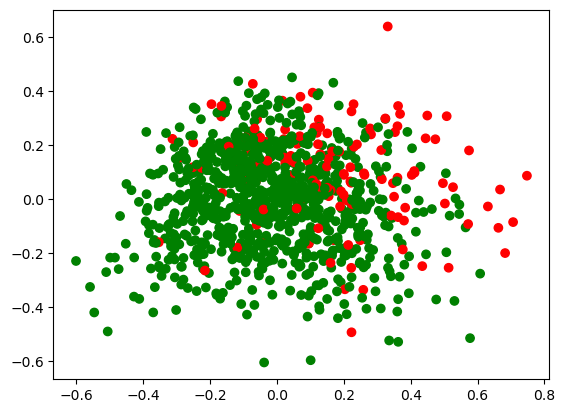

In [317]:
plt.scatter(x = X2D[:,0], y = X2D[:,1], c = col)

# Разделение выборки на тестовую и тренировочную.

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [319]:
data = pd.DataFrame(columns = ['model','roc-auc','accuracy','precision','recall','f1','cross valid','time'])

In [320]:
f_score = make_scorer(f1_score)

# Логистическая регрессия

In [321]:
s = time.time()
clf = LogisticRegression().fit(X_train, y_train)
time_learn = time.time() - s
print('Точность на тренировочной выборке:', clf.score(X_train, y_train))

Точность на тренировочной выборке: 0.8994334277620396


In [322]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.7744186046511627
accuracy: 0.8712871287128713
precision: 0.6428571428571429
recall: 0.20930232558139536
f1: 0.31578947368421056


In [323]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       260
           1       0.64      0.21      0.32        43

    accuracy                           0.87       303
   macro avg       0.76      0.60      0.62       303
weighted avg       0.85      0.87      0.84       303



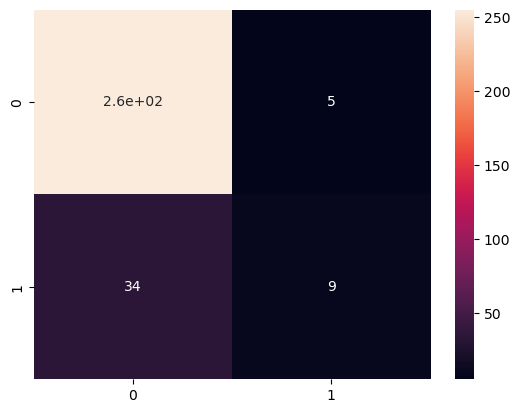

In [324]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [325]:
cv_results = cross_validate(clf, X, y, cv=5, scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',cv_results['test_score'].mean())

Средняя точность на тесте при кросс-валидации: 0.3888399225312401


In [326]:
a = {'model':'LogisticRegression',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results['test_score'].mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)
data

,model,roc-auc,accuracy,precision,recall,f1,cross valid,time
0,LogisticRegression,0.774419,0.871287,0.642857,0.209302,0.315789,0.38884,0.010998


# SVM, kernel = 'rbf'

In [327]:
s = time.time()
clf = SVC(probability = True, kernel = 'rbf').fit(X_train, y_train)
time_learn = time.time()-s
print('Точность на тренировочной выборке:', clf.score(X_train, y_train))

Точность на тренировочной выборке: 0.9277620396600567


In [328]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.7947227191413239
accuracy: 0.8613861386138614
precision: 0.6666666666666666
recall: 0.046511627906976744
f1: 0.08695652173913045


In [329]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       260
           1       0.67      0.05      0.09        43

    accuracy                           0.86       303
   macro avg       0.76      0.52      0.51       303
weighted avg       0.84      0.86      0.81       303



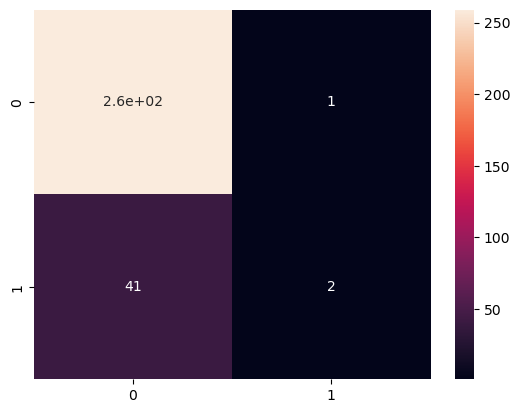

In [330]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [331]:
cv_results = cross_validate(clf, X, y, cv=5, scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',cv_results['test_score'].mean())

Средняя точность на тесте при кросс-валидации: 0.21708115639150122


In [332]:
a = {'model':'SVM, kernel = rbf',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results['test_score'].mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

# SVM, kernel = 'linear'

In [333]:
s = time.time()
clf = SVC(probability = True, kernel = 'linear').fit(X_train, y_train)
time_learn = time.time() - s
print('Точность на тренировочной выборке:', clf.score(X_train, y_train))

Точность на тренировочной выборке: 0.9022662889518414


In [334]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.7797853309481216
accuracy: 0.8745874587458746
precision: 0.6923076923076923
recall: 0.20930232558139536
f1: 0.32142857142857145


In [335]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       260
           1       0.69      0.21      0.32        43

    accuracy                           0.87       303
   macro avg       0.79      0.60      0.63       303
weighted avg       0.86      0.87      0.84       303



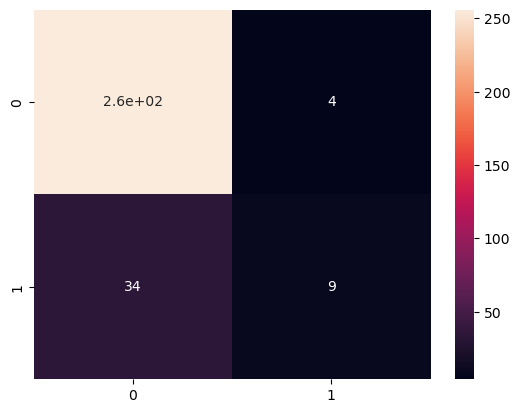

In [336]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [337]:
cv_results = cross_validate(clf, X, y, cv=5, scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',cv_results['test_score'].mean())

Средняя точность на тесте при кросс-валидации: 0.31402246920273486


In [338]:
a = {'model':'SVM, kernel = linear',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results['test_score'].mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

# SVM, kernel = 'poly'

In [339]:
s = time.time()
clf = SVC(probability = True, kernel = 'poly').fit(X_train, y_train)
time_learn = time.time()-s
print('Точность на тренировочной выборке:', clf.score(X_train, y_train))

Точность на тренировочной выборке: 0.9376770538243626


In [340]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.7086762075134169
accuracy: 0.8613861386138614
precision: 0.5714285714285714
recall: 0.09302325581395349
f1: 0.16


In [341]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92       260
           1       0.57      0.09      0.16        43

    accuracy                           0.86       303
   macro avg       0.72      0.54      0.54       303
weighted avg       0.83      0.86      0.82       303



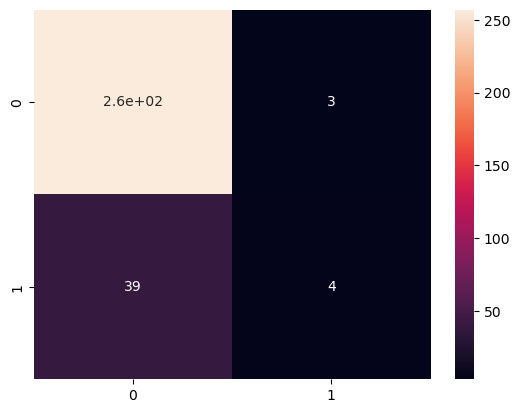

In [342]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [343]:
cv_results = cross_validate(clf, X, y, cv=5,scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',cv_results['test_score'].mean())

Средняя точность на тесте при кросс-валидации: 0.20993612078977933


In [344]:
a = {'model':'SVM, kernel = poly',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results['test_score'].mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

# SVM, kernel = 'sigmoid'

In [345]:
s = time.time()
clf = SVC(probability = True, kernel = 'sigmoid').fit(X_train, y_train)
time_learn = time.time()-s
print('Точность на тренировочной выборке:', clf.score(X_train, y_train))

Точность на тренировочной выборке: 0.8640226628895185


In [346]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.7761627906976744
accuracy: 0.8712871287128713
precision: 0.6428571428571429
recall: 0.20930232558139536
f1: 0.31578947368421056


In [347]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       260
           1       0.64      0.21      0.32        43

    accuracy                           0.87       303
   macro avg       0.76      0.60      0.62       303
weighted avg       0.85      0.87      0.84       303



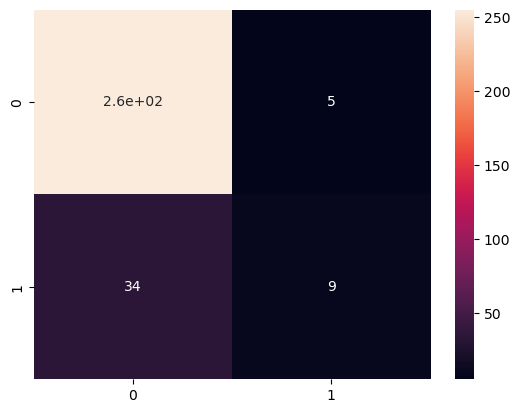

In [348]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [349]:
cv_results = cross_validate(clf, X, y, cv=5,scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',cv_results['test_score'].mean())

Средняя точность на тесте при кросс-валидации: 0.3007843137254902


In [350]:
a = {'model':'SVM, kernel = sigmoid',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results['test_score'].mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

# DecisionTreeClassifier

In [351]:
s = time.time()
clf = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train)
time_learn = time.time()-s
print('Точность на тренировочной выборке:', clf.score(X_train, y_train))

Точность на тренировочной выборке: 0.9305949008498584


In [352]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.5761627906976745
accuracy: 0.8547854785478548
precision: 0.47619047619047616
recall: 0.23255813953488372
f1: 0.3125


In [353]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       260
           1       0.48      0.23      0.31        43

    accuracy                           0.85       303
   macro avg       0.68      0.60      0.62       303
weighted avg       0.83      0.85      0.83       303



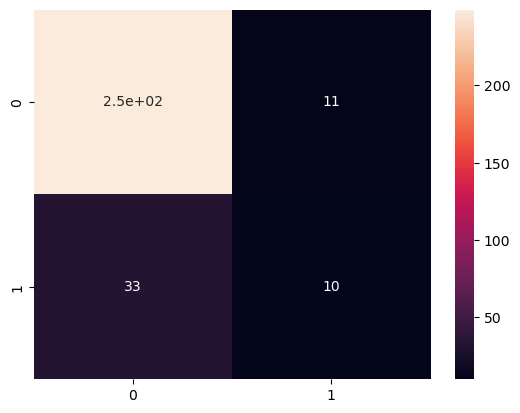

In [354]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [355]:
cv_results = cross_validate(clf, X, y, cv=5,scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',cv_results['test_score'].mean())

Средняя точность на тесте при кросс-валидации: 0.20279673542831436


In [356]:
a = {'model':'DecisionTreeClassifier',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results['test_score'].mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

# RandomForestClassifier

In [357]:
s = time.time()
clf = RandomForestClassifier(max_depth = 5).fit(X_train, y_train)
time_learn = time.time() - s
print('Точность на тренировочной выборке:', clf.score(X_train, y_train))

Точность на тренировочной выборке: 0.9121813031161473


In [358]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.8044722719141324
accuracy: 0.8712871287128713
precision: 0.8333333333333334
recall: 0.11627906976744186
f1: 0.20408163265306123


In [359]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       260
           1       0.83      0.12      0.20        43

    accuracy                           0.87       303
   macro avg       0.85      0.56      0.57       303
weighted avg       0.87      0.87      0.83       303



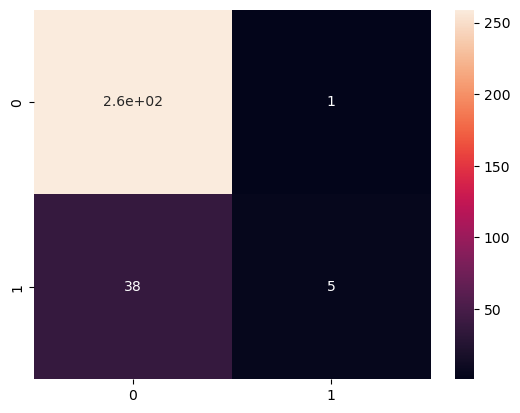

In [360]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [361]:
cv_results = cross_validate(clf, X, y, cv=5,scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',cv_results['test_score'].mean())

Средняя точность на тесте при кросс-валидации: 0.1726327312534209


In [362]:
a = {'model':'RandomForestClassifier',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results['test_score'].mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

# KNN

In [363]:
s = time.time()
clf = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)
time_learn = time.time()-s
print('Точность на тренировочной выборке:', clf.score(X_train, y_train))

Точность на тренировочной выборке: 0.9249291784702549


In [364]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.6500447227191413
accuracy: 0.8646864686468647
precision: 0.5833333333333334
recall: 0.16279069767441862
f1: 0.2545454545454546


In [365]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       260
           1       0.58      0.16      0.25        43

    accuracy                           0.86       303
   macro avg       0.73      0.57      0.59       303
weighted avg       0.83      0.86      0.83       303



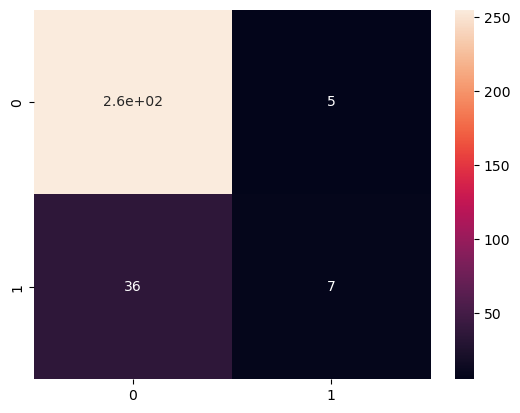

In [366]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [367]:
cv_results = cross_validate(clf, X, y, cv=5,scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',cv_results['test_score'].mean())

Средняя точность на тесте при кросс-валидации: 0.2225140056022409


In [368]:
a = {'model':'KNN',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results['test_score'].mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

# GradientBoostingClassifier

In [369]:
s = time.time()
clf = GradientBoostingClassifier(max_depth = 3).fit(X_train, y_train)
time_learn = time.time()-s
print('Точность на тренировочной выборке:', clf.score(X_train, y_train))

Точность на тренировочной выборке: 0.9886685552407932


In [370]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.8067978533094812
accuracy: 0.8712871287128713
precision: 0.6428571428571429
recall: 0.20930232558139536
f1: 0.31578947368421056


In [371]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       260
           1       0.64      0.21      0.32        43

    accuracy                           0.87       303
   macro avg       0.76      0.60      0.62       303
weighted avg       0.85      0.87      0.84       303



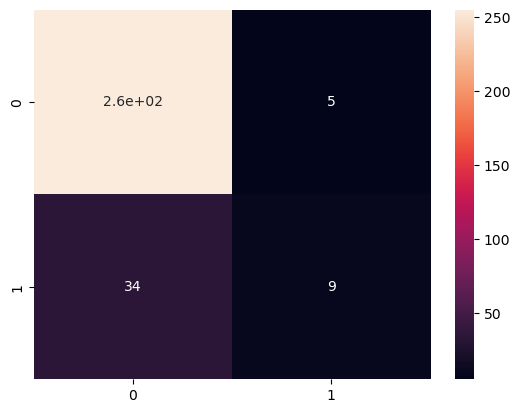

In [372]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [373]:
cv_results = cross_validate(clf, X, y, cv=5,scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',cv_results['test_score'].mean())

Средняя точность на тесте при кросс-валидации: 0.29101010101010105


In [374]:
a = {'model':'GradientBoostingClassifier',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results['test_score'].mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

# XGBoost

In [375]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
d = xgb.DMatrix(X, label=y)
param = {'max_depth': 3, 'eta': 1, 'objective': 'binary:logistic'}
evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 10

In [376]:
s = time.time()
clf = xgb.train(param, dtrain, num_round, evallist)
time_learn = time.time()-s
print('Точность на тренировочной выборке:', accuracy_score(y_train,list(map(lambda x: round(x), clf.predict(dtrain)))))

[0]	train-logloss:0.33149	eval-logloss:0.39640
[1]	train-logloss:0.25911	eval-logloss:0.38632
[2]	train-logloss:0.21572	eval-logloss:0.38368
[3]	train-logloss:0.18717	eval-logloss:0.37078
[4]	train-logloss:0.15723	eval-logloss:0.38040
[5]	train-logloss:0.13666	eval-logloss:0.38145
[6]	train-logloss:0.11354	eval-logloss:0.38853
[7]	train-logloss:0.09689	eval-logloss:0.39548
[8]	train-logloss:0.08802	eval-logloss:0.40386
[9]	train-logloss:0.07526	eval-logloss:0.42064
Точность на тренировочной выборке: 0.9872521246458924


In [377]:
y_pred = list(map(lambda x: round(x), clf.predict(dtest)))
y_score = clf.predict(dtest)
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.7744186046511629
accuracy: 0.8679867986798679
precision: 0.5652173913043478
recall: 0.3023255813953488
f1: 0.39393939393939387


In [378]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       260
           1       0.57      0.30      0.39        43

    accuracy                           0.87       303
   macro avg       0.73      0.63      0.66       303
weighted avg       0.85      0.87      0.85       303



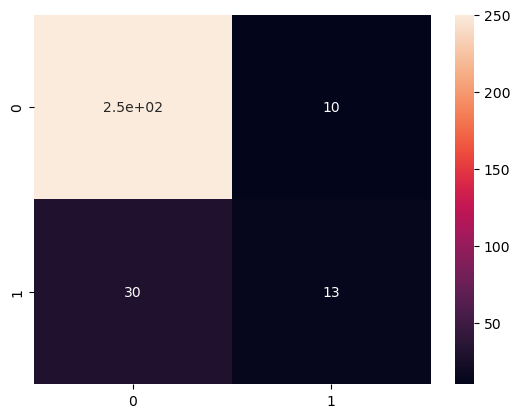

In [379]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [380]:
xgb_clf = xgb.XGBClassifier(max_depth=5, n_estimators=100,
                            objective='binary:logistic', eta = 1)
cv_results = cross_val_score(xgb_clf, X, y,
                         scoring=f_score,
                         cv=5, n_jobs=-1)
print('Средняя точность на тесте при кросс-валидации:',cv_results.mean())

Средняя точность на тесте при кросс-валидации: 0.2834095266322375


In [381]:
a = {'model':'XGBoost',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results.mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

# GaussianNB

In [382]:
s = time.time()
clf = GaussianNB().fit(X_train, y_train)
time_learn = time.time()-s
print('Точность на тренировочной выборке:', clf.score(X_train, y_train))

Точность на тренировочной выборке: 0.8484419263456091


In [383]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test).max(axis = 1)
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.45912343470483
accuracy: 0.8415841584158416
precision: 0.43902439024390244
recall: 0.4186046511627907
f1: 0.4285714285714286


In [384]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       260
           1       0.44      0.42      0.43        43

    accuracy                           0.84       303
   macro avg       0.67      0.67      0.67       303
weighted avg       0.84      0.84      0.84       303



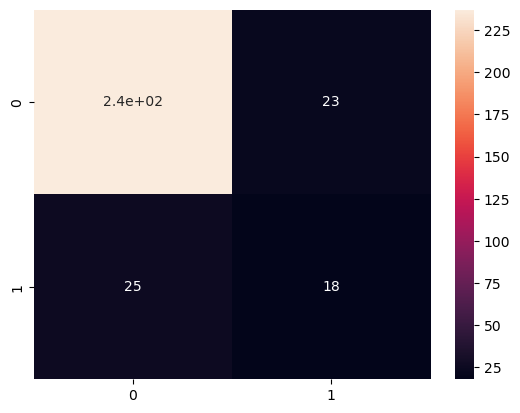

In [385]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [386]:
cv_results = cross_validate(clf, X, y, cv=5,scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',cv_results['test_score'].mean())

Средняя точность на тесте при кросс-валидации: 0.39640619088122353


In [387]:
a = {'model':'GaussianNB',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results['test_score'].mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

In [388]:
data

,model,roc-auc,accuracy,precision,recall,f1,cross valid,time
0,LogisticRegression,0.774419,0.871287,0.642857,0.209302,0.315789,0.388840,0.010998
1,"SVM, kernel = rbf",0.794723,0.861386,0.666667,0.046512,0.086957,0.217081,0.123480
2,"SVM, kernel = linear",0.779785,0.874587,0.692308,0.209302,0.321429,0.314022,0.223892
3,"SVM, kernel = poly",0.708676,0.861386,0.571429,0.093023,0.160000,0.209936,0.084978
4,"SVM, kernel = sigmoid",0.776163,0.871287,0.642857,0.209302,0.315789,0.300784,0.053657
5,DecisionTreeClassifier,0.576163,0.854785,0.476190,0.232558,0.312500,0.202797,0.013896
6,RandomForestClassifier,0.804472,0.871287,0.833333,0.116279,0.204082,0.172633,0.239368
7,KNN,0.650045,0.864686,0.583333,0.162791,0.254545,0.222514,0.000000
8,GradientBoostingClassifier,0.806798,0.871287,0.642857,0.209302,0.315789,0.291010,0.523557
9,XGBoost,0.774419,0.867987,0.565217,0.302326,0.393939,0.283410,0.052759


В результате можно выделить следующие модели:

RandomForestClassifier - обладает самым высоким значением ROC-AUC

LogisticRegression - обладает высоким roc-auc и f1-мерой

GaussianNB - обладает самым высоким значением на кросс-валидации

Попробуем улучшить данные модели с помощью поиска гиперпараметров GridSearch

# LogisticRegression

In [389]:
f1 = f_score

In [390]:
clf = LogisticRegression()

parameters = {'C':[0.001, 0.01, 0.1, 1, 10], 'solver':['newton-cg', 'lbfgs', 'liblinear', 
                                                       'sag', 'saga']}

clf_search = GridSearchCV(clf, parameters, scoring = f1)
clf_search.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring=make_scorer(f1_score))

In [391]:
clf_search.best_params_

{'C': 0.001, 'solver': 'liblinear'}

In [392]:
s = time.time()
clf = LogisticRegression(C = 0.001, solver = 'liblinear').fit(X_train, y_train)
time_learn = time.time()-s
print('Точность на тренировочной выборке:', clf.score(X_train, y_train))

Точность на тренировочной выборке: 0.8739376770538244


In [393]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.7822003577817532
accuracy: 0.8613861386138614
precision: 0.5128205128205128
recall: 0.46511627906976744
f1: 0.4878048780487805


In [394]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       260
           1       0.51      0.47      0.49        43

    accuracy                           0.86       303
   macro avg       0.71      0.70      0.70       303
weighted avg       0.86      0.86      0.86       303



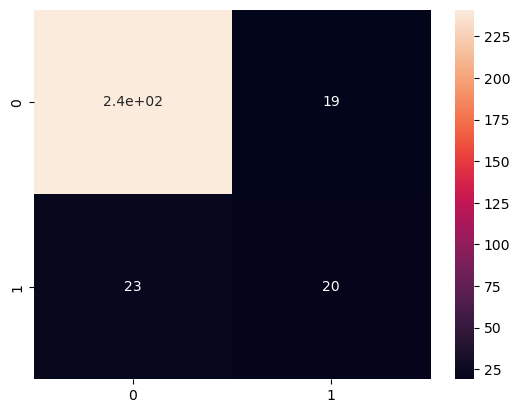

In [395]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [396]:
cv_results = cross_validate(clf, X, y, cv=5,scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',cv_results['test_score'].mean())

Средняя точность на тесте при кросс-валидации: 0.4218313128423069


In [397]:
a = {'model':'LogisticRegression, GridSearch',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results['test_score'].mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

# RandomForestClassifier

In [398]:
clf = RandomForestClassifier()

parameters = {'criterion':['gini','entropy','log_loss'],
              'max_depth': [2, 3, 4, 5, 6]}

clf_search = GridSearchCV(clf, parameters, scoring = f1)
clf_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4, 5, 6]},
             scoring=make_scorer(f1_score))

In [399]:
clf_search.best_params_

{'criterion': 'gini', 'max_depth': 6}

In [400]:
s = time.time()
clf = RandomForestClassifier(criterion = 'gini', max_depth = 6).fit(X_train, y_train)
time_learn = time.time()-s
print('Точность на тренировочной выборке:', clf.score(X_train, y_train))

Точность на тренировочной выборке: 0.9277620396600567


In [401]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.7992844364937388
accuracy: 0.8679867986798679
precision: 0.8
recall: 0.09302325581395349
f1: 0.16666666666666666


In [402]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       260
           1       0.80      0.09      0.17        43

    accuracy                           0.87       303
   macro avg       0.83      0.54      0.55       303
weighted avg       0.86      0.87      0.82       303



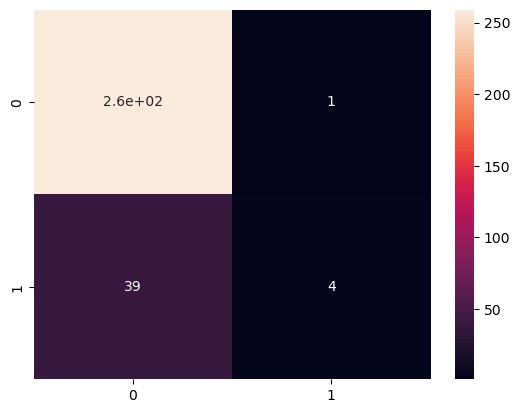

In [403]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [404]:
cv_results = cross_validate(clf, X, y, cv=5,scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',cv_results['test_score'].mean())

Средняя точность на тесте при кросс-валидации: 0.16774064705099184


In [405]:
a = {'model':'RandomForestClassifier, GridSearch',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results['test_score'].mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

# GaussianNB

In [406]:
clf = GaussianNB()

parameters = {'var_smoothing':[10**(-9),10**(-8),10**(-7),10**(-6),
                               10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),1,10,100]}

clf_search = GridSearchCV(clf, parameters,scoring = f1)
clf_search.fit(X_train, y_train)

GridSearchCV(estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                           0.0001, 0.001, 0.01, 0.1, 1, 10,
                                           100]},
             scoring=make_scorer(f1_score))

In [407]:
clf_search.best_params_

{'var_smoothing': 0.1}

In [408]:
s = time.time()
clf = GaussianNB(var_smoothing = 0.1).fit(X_train, y_train)
time_learn = time.time()-s
print('Точность на тренировочной выборке:', clf.score(X_train, y_train))

Точность на тренировочной выборке: 0.8526912181303116


In [409]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.7760286225402504
accuracy: 0.8481848184818482
precision: 0.46153846153846156
recall: 0.4186046511627907
f1: 0.4390243902439025


In [410]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       260
           1       0.46      0.42      0.44        43

    accuracy                           0.85       303
   macro avg       0.68      0.67      0.68       303
weighted avg       0.84      0.85      0.85       303



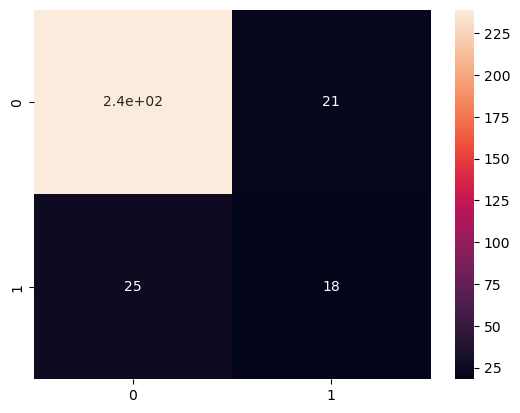

In [411]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [412]:
cv_results = cross_validate(clf, X, y, cv=5,scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',cv_results['test_score'].mean())

Средняя точность на тесте при кросс-валидации: 0.41082229423692834


In [413]:
a = {'model':'GaussianNB, GridSearch',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results['test_score'].mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

# Введение сурогатных признаков

In [414]:
pca = KernelPCA(n_components = 5, kernel="sigmoid", gamma = 0.03)
X2D= pca.fit_transform(X)
X_new = np.hstack([X, X2D])

In [415]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

# LogisticRegression

In [416]:
s = time.time()
clf = LogisticRegression(C = 0.001, solver = 'liblinear').fit(X_train, y_train)
time_learn = time.time()-s
print('Точность на тренировочной выборке:', clf.score(X_train, y_train))

Точность на тренировочной выборке: 0.8739376770538244


In [417]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.7821109123434705
accuracy: 0.8613861386138614
precision: 0.5128205128205128
recall: 0.46511627906976744
f1: 0.4878048780487805


In [418]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       260
           1       0.51      0.47      0.49        43

    accuracy                           0.86       303
   macro avg       0.71      0.70      0.70       303
weighted avg       0.86      0.86      0.86       303



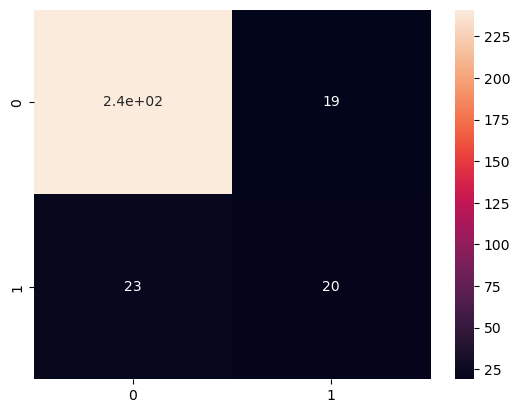

In [419]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [420]:
cv_results = cross_validate(clf, X_new, y, cv=5,scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',cv_results['test_score'].mean())

Средняя точность на тесте при кросс-валидации: 0.43101615847355096


In [421]:
a = {'model':'LogisticRegression, PCA',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results['test_score'].mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

# RandomForestClassifier

In [422]:
s = time.time()
clf = RandomForestClassifier(criterion = 'gini', max_depth = 6).fit(X_train, y_train)
time_learn = time.time()-s
print('Точность на тренировочной выборке:', clf.score(X_train, y_train))

Точность на тренировочной выборке: 0.9291784702549575


In [423]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.8027728085867621
accuracy: 0.8679867986798679
precision: 0.8
recall: 0.09302325581395349
f1: 0.16666666666666666


In [424]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       260
           1       0.80      0.09      0.17        43

    accuracy                           0.87       303
   macro avg       0.83      0.54      0.55       303
weighted avg       0.86      0.87      0.82       303



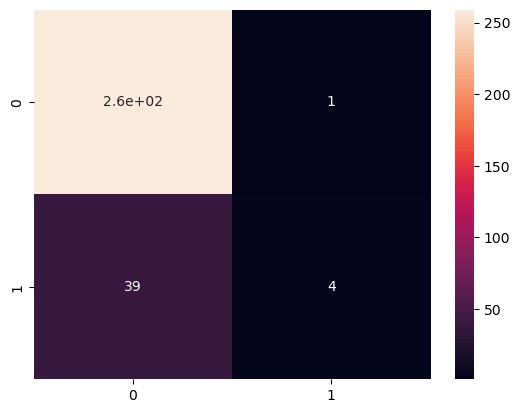

In [425]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [426]:
cv_results = cross_validate(clf, X_new, y, cv=5,scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',cv_results['test_score'].mean())

Средняя точность на тесте при кросс-валидации: 0.22451794809604655


In [427]:
a = {'model':'RandomForestClassifier, PCA',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results['test_score'].mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

# GaussianNB

In [428]:
s = time.time()
clf = GaussianNB(var_smoothing = 0.1).fit(X_train, y_train)
time_learn = time.time()-s
print('Точность на тренировочной выборке:', clf.score(X_train, y_train))

Точность на тренировочной выборке: 0.8526912181303116


In [429]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.7764758497316636
accuracy: 0.8481848184818482
precision: 0.46153846153846156
recall: 0.4186046511627907
f1: 0.4390243902439025


In [430]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       260
           1       0.46      0.42      0.44        43

    accuracy                           0.85       303
   macro avg       0.68      0.67      0.68       303
weighted avg       0.84      0.85      0.85       303



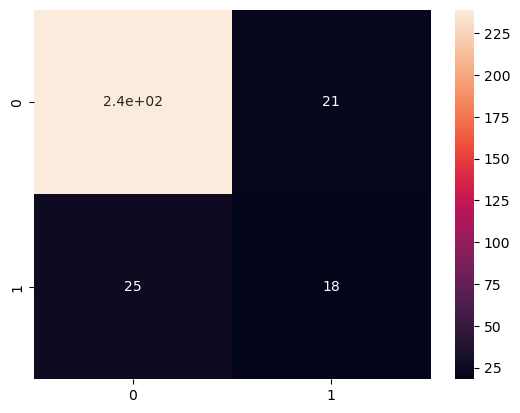

In [431]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [432]:
cv_results = cross_validate(clf, X_new, y, cv=5, scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',cv_results['test_score'].mean())

Средняя точность на тесте при кросс-валидации: 0.41019062904308806


In [433]:
a = {'model':'GaussianNB, PCA',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':cv_results['test_score'].mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

# Ансамблирование моделей

In [434]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [435]:
kfold = model_selection.KFold(n_splits=5)
cart = GaussianNB(var_smoothing = 0.1)
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees)
results = model_selection.cross_val_score(model, X, y, cv=kfold,scoring=f_score)

In [436]:
print('Средняя точность на тесте при кросс-валидации:',results.mean())

Средняя точность на тесте при кросс-валидации: 0.39499958228905596


In [437]:
s = time.time()
clf = model.fit(X_train, y_train)
time_learn = time.time() - s

In [438]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.7846153846153846
accuracy: 0.8547854785478548
precision: 0.4864864864864865
recall: 0.4186046511627907
f1: 0.45


In [439]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       260
           1       0.49      0.42      0.45        43

    accuracy                           0.85       303
   macro avg       0.70      0.67      0.68       303
weighted avg       0.85      0.85      0.85       303



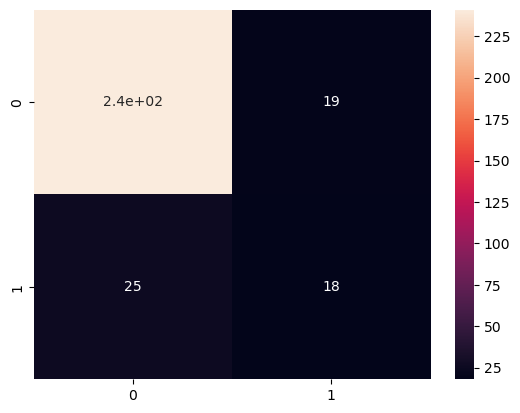

In [440]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [441]:
a = {'model':'Bagging GaussianNB',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':results.mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

In [442]:
kfold = model_selection.KFold(n_splits=5)
cart = LogisticRegression(C = 0.001, solver = 'liblinear')
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees)
results = model_selection.cross_val_score(model, X, y, cv=kfold,scoring=f_score)

In [443]:
print('Средняя точность на тесте при кросс-валидации:',results.mean())

Средняя точность на тесте при кросс-валидации: 0.40026719632396784


In [444]:
s = time.time()
clf = model.fit(X_train, y_train)
time_learn = time.time() - s

In [445]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.785778175313059
accuracy: 0.8547854785478548
precision: 0.4864864864864865
recall: 0.4186046511627907
f1: 0.45


In [446]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       260
           1       0.49      0.42      0.45        43

    accuracy                           0.85       303
   macro avg       0.70      0.67      0.68       303
weighted avg       0.85      0.85      0.85       303



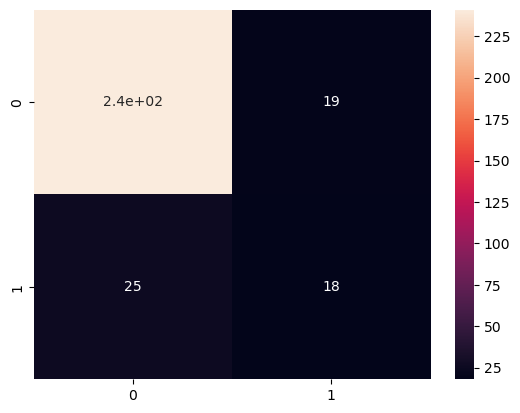

In [447]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [448]:
a = {'model':'Bagging LogisticRegression',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':results.mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

In [449]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

In [450]:
kfold = model_selection.KFold(n_splits=5)
cart = GaussianNB(var_smoothing = 0.1)
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees)
results = model_selection.cross_val_score(model, X_new, y, cv=kfold,scoring=f_score)

In [451]:
print('Средняя точность на тесте при кросс-валидации:',results.mean())

Средняя точность на тесте при кросс-валидации: 0.3937450904041293


In [452]:
s = time.time()
clf = model.fit(X_train, y_train)
time_learn = time.time() - s

In [453]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.7869409660107335
accuracy: 0.8514851485148515
precision: 0.47368421052631576
recall: 0.4186046511627907
f1: 0.4444444444444444


In [454]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       260
           1       0.47      0.42      0.44        43

    accuracy                           0.85       303
   macro avg       0.69      0.67      0.68       303
weighted avg       0.84      0.85      0.85       303



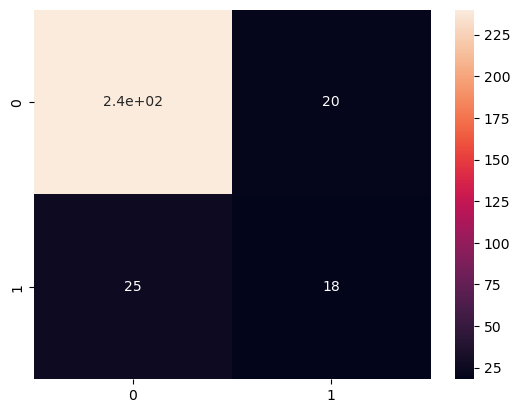

In [455]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [456]:
a = {'model':'Bagging GaussianNB PCA',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':results.mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

In [457]:
kfold = model_selection.KFold(n_splits=5)
cart = LogisticRegression(C = 0.001, solver = 'liblinear')
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees)
results = model_selection.cross_val_score(model, X_new, y, cv=kfold,scoring=f_score)

In [458]:
print('Средняя точность на тесте при кросс-валидации:',results.mean())

Средняя точность на тесте при кросс-валидации: 0.3963442565186751


In [459]:
s = time.time()
clf = model.fit(X_train, y_train)
time_learn = time.time() - s

In [460]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.7802325581395348
accuracy: 0.8712871287128713
precision: 0.5588235294117647
recall: 0.4418604651162791
f1: 0.49350649350649345


In [461]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       260
           1       0.56      0.44      0.49        43

    accuracy                           0.87       303
   macro avg       0.73      0.69      0.71       303
weighted avg       0.86      0.87      0.86       303



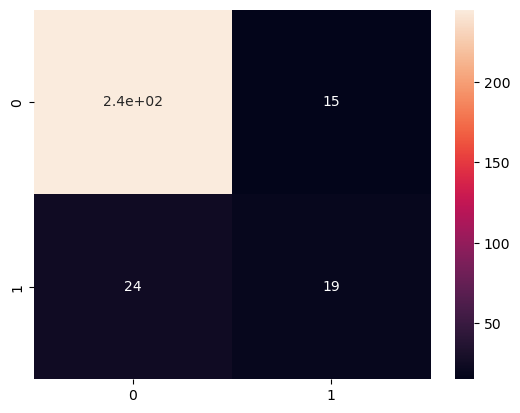

In [462]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [463]:
a = {'model':'Bagging LogisticRegression PCA',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':results.mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

# Голосующий ансамбль

In [464]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [465]:
kfold = model_selection.KFold(n_splits=5)
estimators = []
model1 = GaussianNB(var_smoothing = 0.1)
estimators.append(('GaussianNB', model1))
model2 = LogisticRegression(C = 0.001, solver = 'liblinear')
estimators.append(('LogisticRegression', model2))
model3 = RandomForestClassifier(criterion = 'gini', max_depth = 6)
estimators.append(('RandomForestClassifier', model3))
ensemble = VotingClassifier(estimators, voting = 'soft')
results = model_selection.cross_val_score(ensemble, X, y, cv=kfold,scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',results.mean())

Средняя точность на тесте при кросс-валидации: 0.3869359488832106


In [466]:
s = time.time()
clf = ensemble.fit(X_train, y_train)
time_learn = time.time() - s

In [467]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.806350626118068
accuracy: 0.858085808580858
precision: 0.5
recall: 0.37209302325581395
f1: 0.42666666666666664


In [468]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       260
           1       0.50      0.37      0.43        43

    accuracy                           0.86       303
   macro avg       0.70      0.66      0.67       303
weighted avg       0.84      0.86      0.85       303



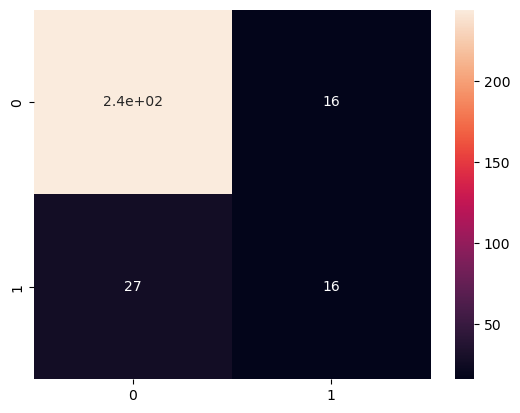

In [469]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [470]:
a = {'model':'VotingClassifier, model 3',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':results.mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

In [492]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

In [493]:
kfold = model_selection.KFold(n_splits=5)
estimators = []
model1 = GaussianNB(var_smoothing = 0.1)
estimators.append(('GaussianNB', model1))
model2 = LogisticRegression(C = 0.001, solver = 'liblinear')
estimators.append(('LogisticRegression', model2))
ensemble = VotingClassifier(estimators, voting = 'soft')
results = model_selection.cross_val_score(ensemble, X, y, cv=kfold,scoring=f_score)
print('Средняя точность на тесте при кросс-валидации:',results.mean())

Средняя точность на тесте при кросс-валидации: 0.3840122648249583


In [494]:
s = time.time()
clf = ensemble.fit(X_train, y_train)
time_learn = time.time() - s

In [495]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print('roc-auc:', roc_auc_score(y_test, y_score))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.7839892665474061
accuracy: 0.8481848184818482
precision: 0.46153846153846156
recall: 0.4186046511627907
f1: 0.4390243902439025


In [496]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       260
           1       0.46      0.42      0.44        43

    accuracy                           0.85       303
   macro avg       0.68      0.67      0.68       303
weighted avg       0.84      0.85      0.85       303



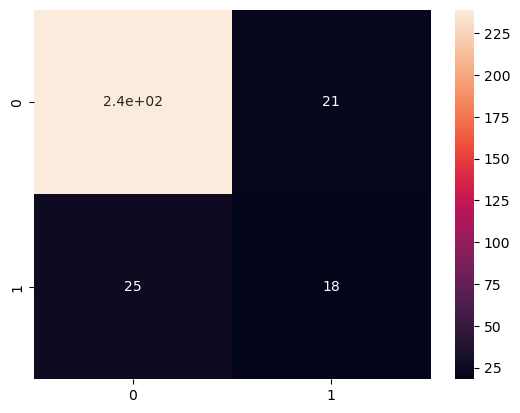

In [497]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [477]:
a = {'model':'VotingClassifier, model 2, PCA',
     'roc-auc':roc_auc_score(y_test, y_score),
     'accuracy':accuracy_score(y_test, y_pred),
     'precision':precision_score(y_test, y_pred),
     'recall':recall_score(y_test, y_pred),
     'f1':f1_score(y_test, y_pred),
     'cross valid':results.mean(),
     'time':time_learn}
data = data.append(a, ignore_index = True)

In [478]:
data

,model,roc-auc,accuracy,precision,recall,f1,cross valid,time
0,LogisticRegression,0.774419,0.871287,0.642857,0.209302,0.315789,0.388840,0.010998
1,"SVM, kernel = rbf",0.794723,0.861386,0.666667,0.046512,0.086957,0.217081,0.123480
2,"SVM, kernel = linear",0.779785,0.874587,0.692308,0.209302,0.321429,0.314022,0.223892
3,"SVM, kernel = poly",0.708676,0.861386,0.571429,0.093023,0.160000,0.209936,0.084978
4,"SVM, kernel = sigmoid",0.776163,0.871287,0.642857,0.209302,0.315789,0.300784,0.053657
5,DecisionTreeClassifier,0.576163,0.854785,0.476190,0.232558,0.312500,0.202797,0.013896
6,RandomForestClassifier,0.804472,0.871287,0.833333,0.116279,0.204082,0.172633,0.239368
7,KNN,0.650045,0.864686,0.583333,0.162791,0.254545,0.222514,0.000000
8,GradientBoostingClassifier,0.806798,0.871287,0.642857,0.209302,0.315789,0.291010,0.523557
9,XGBoost,0.774419,0.867987,0.565217,0.302326,0.393939,0.283410,0.052759
